In [1]:
from pathlib import Path

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import solve_ivp
import scipy.stats as stats
from scipy.stats import multivariate_normal as mvn

import arviz as az

import stan

from jax import grad, jacobian
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde as jgaussian_kde

import dask.array as da
from dask.distributed import Client, progress

import dcor

from stein_thinning.thinning import thin, thin_gf

from utils.caching import map_cached, calculate_iterable_cached
import utils.parallel
from utils.parallel import apply_along_axis_parallel, get_map_parallel
from utils.plotting import plot_paths, plot_trace, plot_traces, plot_sample_thinned
from utils.sampling import to_arviz

In [2]:
import nest_asyncio
nest_asyncio.apply()

Directory where results of expensive calculations will be stored:

In [3]:
generated_data_dir = Path('../data') / 'generated'

In [4]:
recalculate = False  # True => perform expensive calculations, False => use stored results
save_data = recalculate
save_rw_results = recalculate
save_hmc_results = recalculate
save_validation_hmc_results = recalculate
save_rw_gradients = recalculate
save_hmc_gradients = recalculate
save_rw_log_p = recalculate
save_hmc_log_p = recalculate

We create a Dask client in order to parallelise calculations where possible:

In [5]:
client = Client(processes=True, threads_per_worker=4, n_workers=4, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42191,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:37227,Total threads: 4
Dashboard: http://127.0.0.1:44139/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:33287,


In [6]:
map_parallel = get_map_parallel(client)

# Generate synthetic data

The Lotka-Volterra model is given by the equations:
$$\begin{split}
\frac{du_1}{dt} &= \theta_1 u_1 - \theta_2 u_1 u_2, \\
\frac{du_2}{dt} &= \theta_4 u_1 u_2 - \theta_3 u_2,
\end{split}$$
where $u_1$ and $u_2$ are populations of prey and preditor, respectively, and $\theta_1, \theta_2, \theta_3, \theta_4$ are model parameters. All the quantities are positive.

Define the Lotka-Volterra model:

In [7]:
def lotka_volterra(t, u, theta):
    theta1, theta2, theta3, theta4 = theta
    u1, u2 = u
    return [
        theta1 * u1 - theta2 * u1 * u2,
        theta4 * u1 * u2 - theta3 * u2,
    ]

Solve the coupled ODEs:

In [8]:
t_n = 2400  # number of time data points
t_span = [0, 25]  # the time span over which to integrate the system
theta = [0.67, 1.33, 1., 1.]  # parameters of the model
q = 2  # number of state variables
d = len(theta)  # dimension of the parameter space
u_init = [1., 1.]  # initial values

In [9]:
def solve_lotka_volterra(theta):
    sol = solve_ivp(lotka_volterra, t_span, u_init, args=(theta,), dense_output=True)
    t = np.linspace(t_span[0], t_span[1], t_n)
    return t, sol.sol(t).T

In [10]:
t, u = solve_lotka_volterra(theta)

Add Gaussian noise:

In [11]:
rng = np.random.default_rng(12345)

In [12]:
means = [0, 0]
C = np.diag([0.2 ** 2, 0.2 ** 2])

In [13]:
eps = stats.multivariate_normal.rvs(mean=means, cov=C, size=len(u), random_state=rng)
y = u + eps

Plot the resulting values:

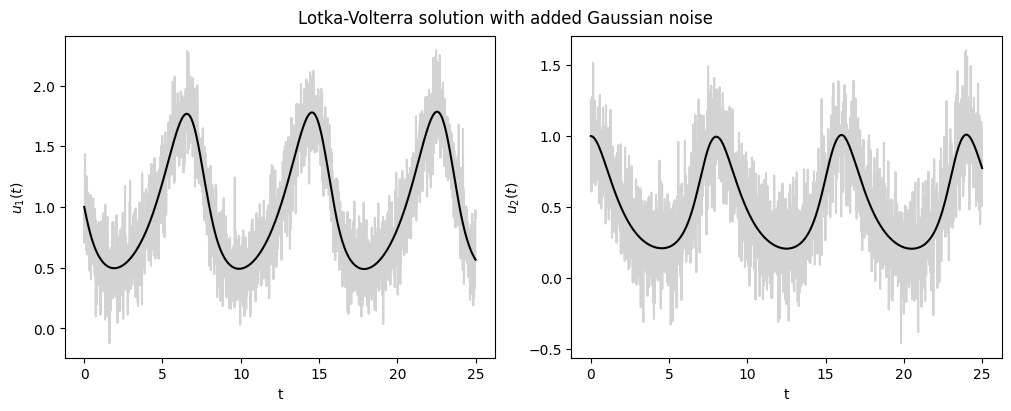

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
fig.suptitle('Lotka-Volterra solution with added Gaussian noise');
for i in range(2):
    axs[i].plot(t, y[:, i], color='lightgray');
    axs[i].plot(t, u[:, i], color='black');
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

In [15]:
if save_data:
    filepath = Path('../data') / 'generated' / 'lotka_volterra_gaussian_noise.csv'
    df = pd.DataFrame({'u1': y[:, 0], 'u2': y[:, 1]}, index=pd.Index(t, name='t'))
    df.to_csv(filepath)

# Sample using a handwritten random-walk Metropolis-Hastings algorithm

Implement random-walk Metropolis-Hastings algorithm by hand:

In [16]:
def sample_chain(theta_sampler, theta_init, n_samples):
    """Sample a single chain of given length using the starting the values provided"""
    # set the starting values
    theta = np.array(theta_init, copy=True)

    # create an array for the trace
    trace = np.empty((n_samples + 1, d))

    # store the initial values
    trace[0, :] = theta

    # sample variables
    for i in range(n_samples):
        # sample new theta
        theta = theta_sampler(theta)

        # record the value in the trace
        trace[i + 1, :] = theta

    return trace

In [17]:
def metropolis_random_walk_step(log_target_density, proposal_sampler, rng):
    """Perform a Metropolis-Hastings random walk step"""
    def sampler(theta):
        # propose a new value
        theta_proposed = proposal_sampler(theta)

        # decide whether to accept the new value
        log_acceptance_probability = np.minimum(
            0, 
            log_target_density(theta_proposed) - log_target_density(theta)
        )
        u = rng.random()
        if u == 0 or np.log(u) < log_acceptance_probability:
            return theta_proposed
        else:
            return theta

    return sampler

In [18]:
def log_target_density(theta):
    _, u = solve_lotka_volterra(np.exp(theta))
    log_likelihood = np.sum(stats.multivariate_normal.logpdf(y - u, mean=means, cov=C))
    log_prior = np.sum(stats.norm.logpdf(theta))
    return log_likelihood + log_prior

In [19]:
def rw_proposal_sampler(step_size, rng):
    G = step_size * np.identity(d)
    def sampler(theta):
        xi = stats.norm.rvs(size=d, random_state=rng)
        return theta + G @ xi
    return sampler

In [20]:
n_samples_rw = 500_000

In [21]:
# TODO consider selecting step size automatically following Gelman, Roberts, Gilks (1996) Efficient Metropolis Jumping Rules.
step_size = 0.0025

We use the initial values from Table S3 in Supplementary Material:

In [22]:
theta_inits = [
    np.array([0.55, 1, 0.8, 0.8]),
    np.array([1.5, 1., 0.8, 0.8]),
    np.array([1.3, 1.33, 0.5, 0.8]),
    np.array([0.55, 3., 3., 0.8]),
    np.array([0.55, 1., 1.5, 1.5]),
]

In [23]:
rw_seed = 12345
def run_rw_sampler(theta_init):
    rng = np.random.default_rng(rw_seed)
    theta_sampler = metropolis_random_walk_step(log_target_density, rw_proposal_sampler(step_size, rng), rng)
    return sample_chain(theta_sampler, np.log(theta_init), n_samples_rw)

In [24]:
%%time
rw_samples = map_cached(
    lambda item: run_rw_sampler(item[1]),
    enumerate(theta_inits),
    lambda item: generated_data_dir / f'rw_chain_{item[0]}_seed_{rw_seed}.csv',
    recalculate=recalculate,
    save=save_rw_results,
    mapper=map_parallel
)

CPU times: user 532 ms, sys: 198 ms, total: 730 ms
Wall time: 7.2 s


Reproduce the first column in Figure S17 from the Supplementary Material:

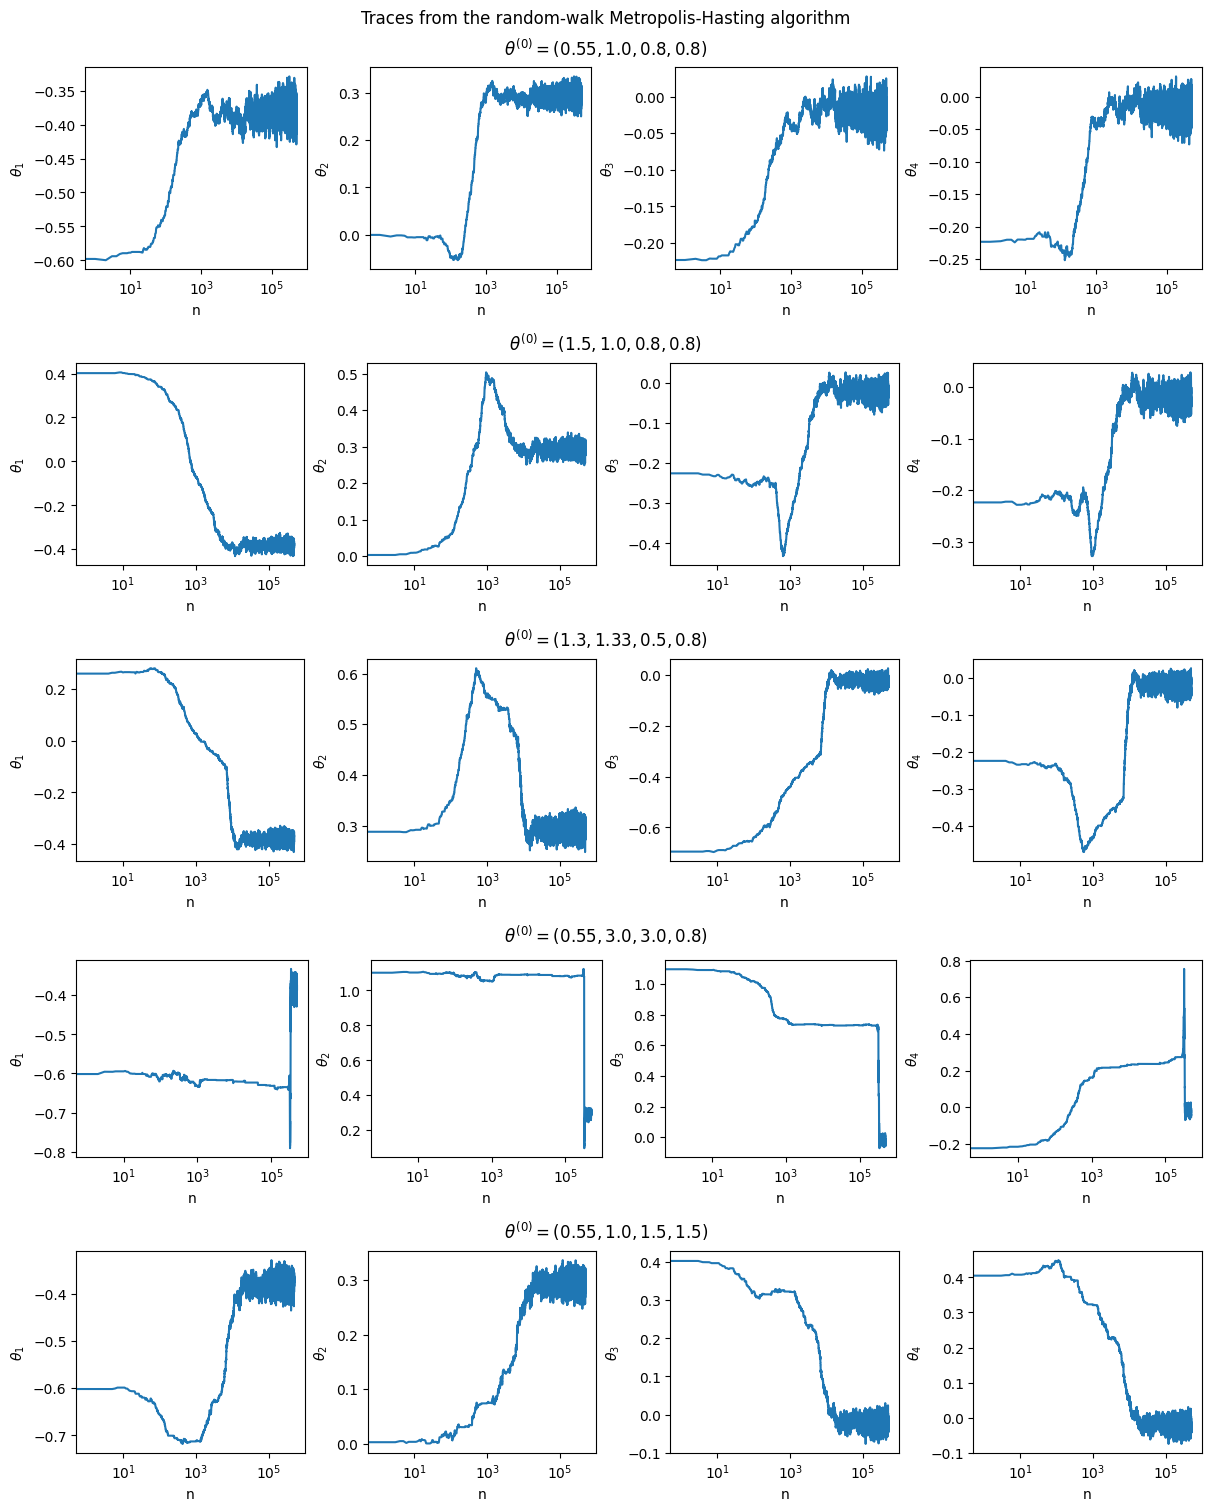

In [25]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in theta_inits]
var_labels = [f'$\\theta_{i + 1}$' for i in range(len(theta_inits))]
fig = plot_traces(rw_samples, titles=titles, var_labels=var_labels);
fig.suptitle('Traces from the random-walk Metropolis-Hasting algorithm');

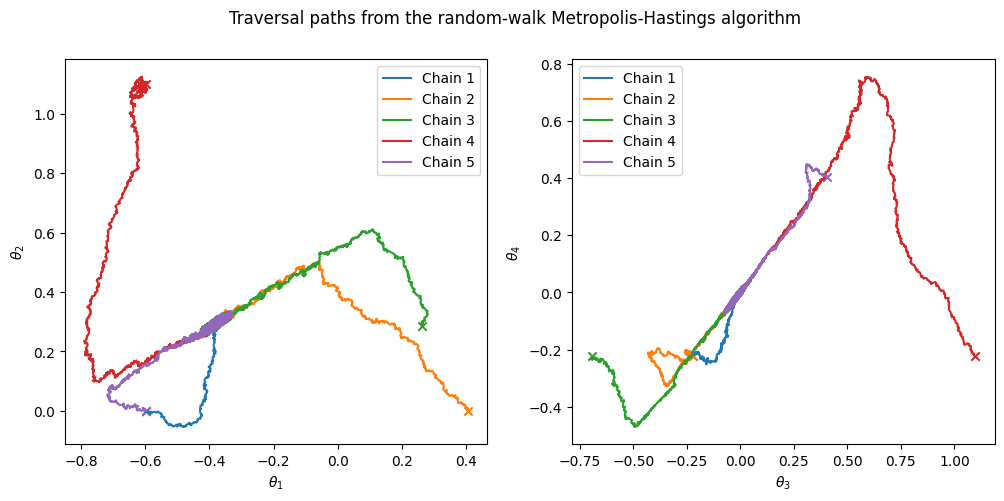

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_paths(rw_samples, np.log(theta_inits), idx1=0, idx2=1, ax=axs[0], label1='$\\theta_1$', label2='$\\theta_2$');
plot_paths(rw_samples, np.log(theta_inits), idx1=2, idx2=3, ax=axs[1], label1='$\\theta_3$', label2='$\\theta_4$');
fig.suptitle('Traversal paths from the random-walk Metropolis-Hastings algorithm');

In [27]:
def acceptance_rate(sample):
    """Fraction of accepted samples"""
    return (np.sum(np.any(sample[1:] != sample[:-1], axis=1)) + 1) / sample.shape[0]

In [28]:
[acceptance_rate(sample) for sample in rw_samples]

[0.2306775386449227,
 0.23022353955292088,
 0.22811954376091248,
 0.07851784296431408,
 0.22772154455691088]

## Convergence diagnostics

``arviz`` implements $\hat{R}$ and the expected sample size as recommended in _Vehtari et al. (2021) Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC_. The paper suggests the minimum ESS of 50 for each chain and the threshold value of 1.01 for $\hat{R}$. Based on these thresholds, the chains would be deemed not to have converged:

In [29]:
%%time
az.summary(to_arviz(rw_samples, var_names=[f'theta{i + 1}' for i in range(d)]))

CPU times: user 1min 20s, sys: 1.82 s, total: 1min 22s
Wall time: 1min 22s


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta1,-0.416,0.091,-0.636,-0.355,0.035,0.026,16.0,19.0,1.23
theta2,0.394,0.267,0.270,1.085,0.108,0.080,17.0,31.0,1.23
theta3,0.078,0.254,-0.044,0.736,0.103,0.077,14.0,13.0,1.28
theta4,0.020,0.105,-0.045,0.273,0.038,0.028,17.0,39.0,1.21


# Sample using Stan

The implementation follows https://mc-stan.org/docs/stan-users-guide/odes.html#estimating-system-parameters-and-initial-state.

In [30]:
stan_model_spec = """
functions {
  vector lotka_volterra(real t, vector u, vector theta) {
    vector[2] dudt;
    dudt[1] = exp(theta[1]) * u[1] - exp(theta[2]) * u[1] * u[2];
    dudt[2] = exp(theta[4]) * u[1] * u[2] - exp(theta[3]) * u[2];
    return dudt;
  }
}
data {
  int<lower=1> T;
  array[T] vector[2] y;
  real t0;
  array[T] real ts;
  vector[2] u0;
  vector<lower=0>[2] sigma;
}
parameters {
  vector[4] theta;
}
model {
  array[T] vector[2] u = ode_rk45(lotka_volterra, u0, t0, ts, theta);
  theta ~ std_normal();
  for (t in 1:T) {
    y[t] ~ normal(u[t], sigma);
  }
}
"""

In [31]:
data = {
    'T': t_n - 1,  # the first time is 0, for which the initial values are fixed
    'y': y[1:, :],
    't0': t_span[0],
    'ts': t[1:],
    'u0': u_init,
    'sigma': np.diag(C),  # TODO pass a matrix and use a multivariate normal in the Stan model
}

In [32]:
n_samples_hmc = 10_000

In [33]:
def extract_chains(stan_sample, param):
    """Extract chains from PyStan fit"""
    param_indices = stan_sample._parameter_indexes(param)
    return [stan_sample._draws[param_indices, :, i_chain].T for i_chain in range(stan_sample.num_chains)]

In [34]:
hmc_seed = 12345

In [35]:
def calculate_hmc():
    inference_model = stan.build(stan_model_spec, data=data, random_seed=hmc_seed)
    stan_sample = inference_model.sample(
        num_chains=len(theta_inits),
        num_samples=n_samples_hmc,
        save_warmup=True,
        init=[{'theta': np.log(theta_init)} for theta_init in theta_inits]
    )
    return extract_chains(stan_sample, 'theta')

In [36]:
%%time
hmc_samples = calculate_iterable_cached(
    calculate_hmc,
    lambda i: generated_data_dir / f'hmc_chain_{i}_seed_{hmc_seed}.csv',
    len(theta_inits),
    recalculate=recalculate,
    save=save_hmc_results,
)

CPU times: user 261 ms, sys: 11.7 ms, total: 273 ms
Wall time: 457 ms


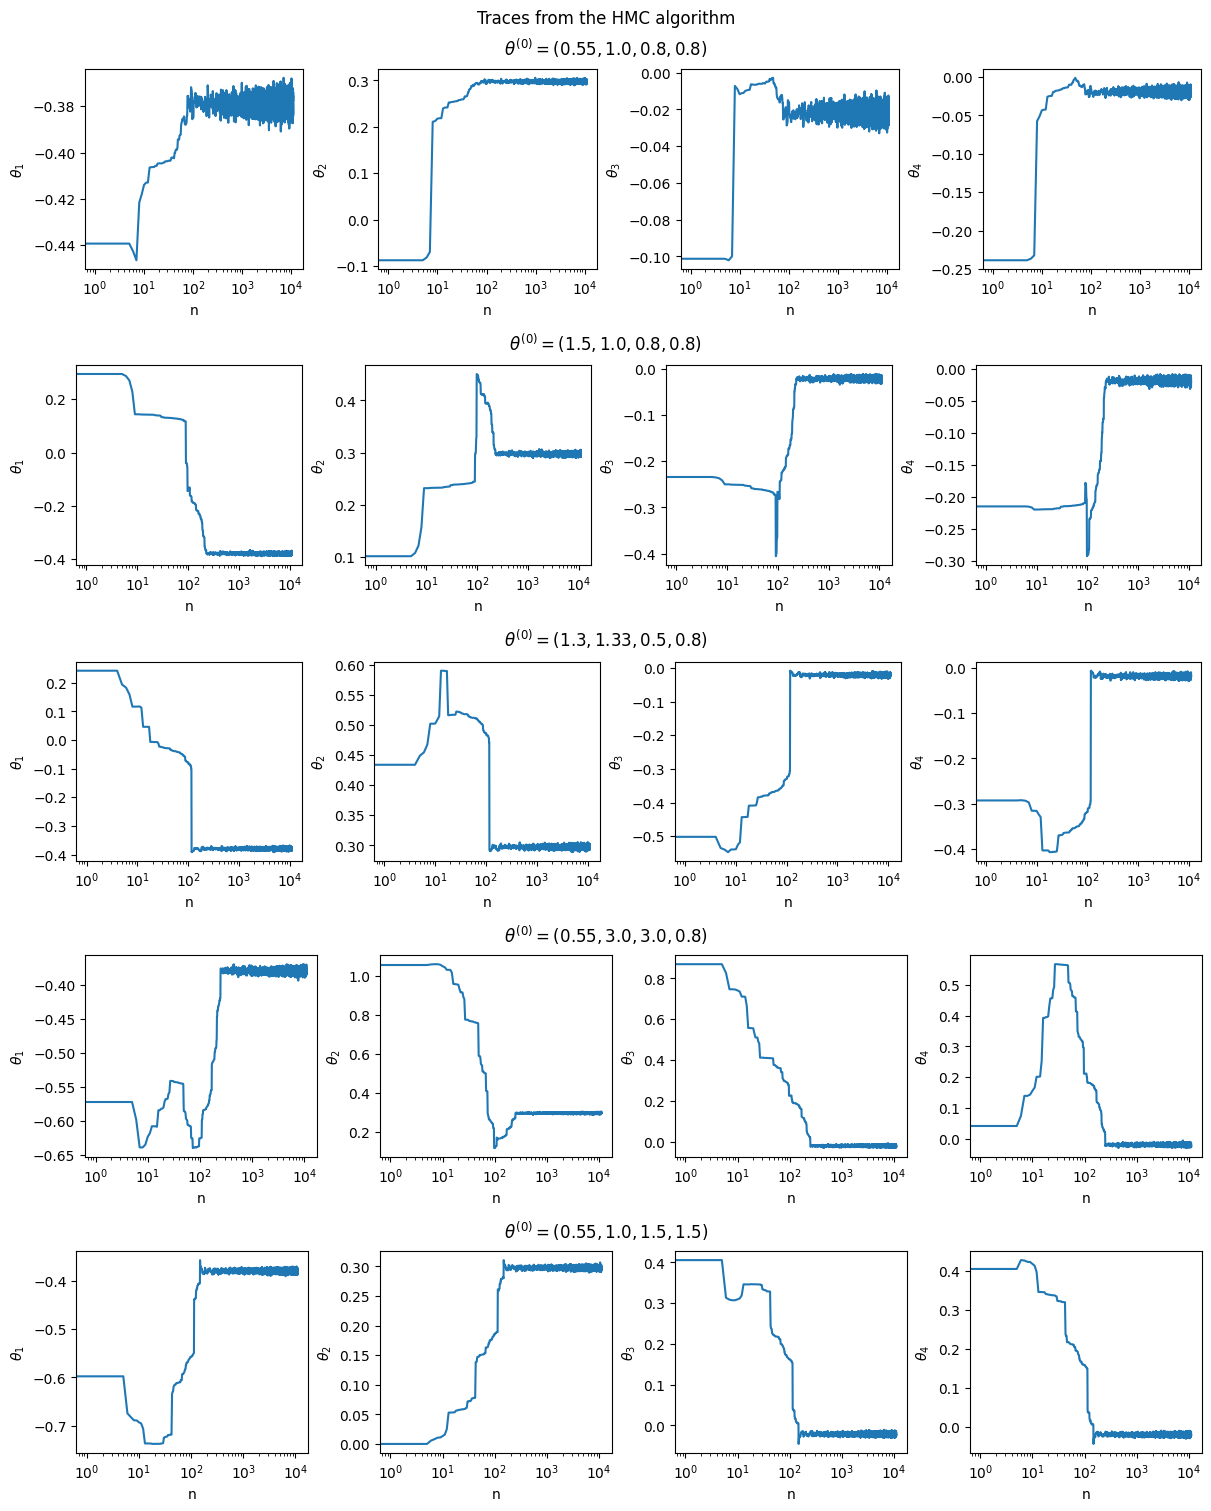

In [37]:
titles = [f'$\\theta^{{(0)}} = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})$' for theta in theta_inits]
var_labels = [f'$\\theta_{i + 1}$' for i in range(len(theta_inits))]
fig = plot_traces(hmc_samples, titles=titles, var_labels=var_labels);
fig.suptitle('Traces from the HMC algorithm');

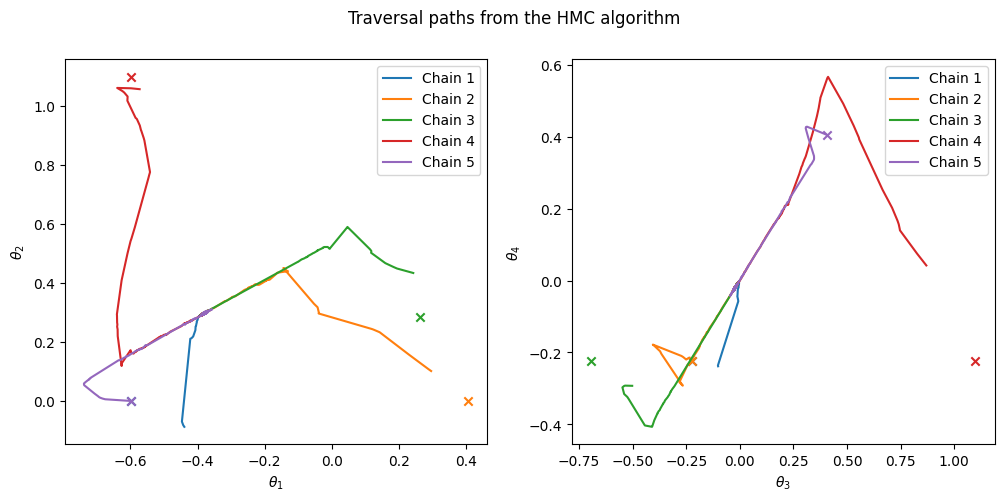

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Traversal paths from the HMC algorithm');
plot_paths(hmc_samples, np.log(theta_inits), idx1=0, idx2=1, ax=axs[0], label1='$\\theta_1$', label2='$\\theta_2$');
plot_paths(hmc_samples, np.log(theta_inits), idx1=2, idx2=3, ax=axs[1], label1='$\\theta_3$', label2='$\\theta_4$');

In [39]:
[acceptance_rate(sample) for sample in hmc_samples]

[0.9900909090909091,
 0.9901818181818182,
 0.9897272727272727,
 0.9905454545454545,
 0.991909090909091]

Based on the thresholds in _Vehtari et al. (2021) Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC_, the diagnostics do not suggest any convergence issues:

In [40]:
az.summary(to_arviz(hmc_samples, var_names=[f'theta{i + 1}' for i in range(d)]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta1,-0.379,0.033,-0.386,-0.373,0.002,0.002,2062.0,1561.0,1.0
theta2,0.298,0.025,0.293,0.302,0.001,0.001,3509.0,2208.0,1.0
theta3,-0.021,0.034,-0.028,-0.015,0.003,0.002,2098.0,1554.0,1.0
theta4,-0.019,0.031,-0.025,-0.013,0.002,0.002,2096.0,1612.0,1.0


### Validation HMC sample

In [41]:
%%time
validation_hmc_seed = 98765

def calculate_hmc_validation():
    inference_model = stan.build(stan_model_spec, data=data, random_seed=validation_hmc_seed)
    stan_sample = inference_model.sample(
        num_chains=len(theta_inits),
        num_samples=n_samples_hmc,
        init=[{'theta': np.log(theta_init)} for theta_init in theta_inits]
    )
    return extract_chains(stan_sample, 'theta')

validation_hmc_samples = calculate_iterable_cached(
    calculate_hmc_validation,
    lambda i: generated_data_dir / f'hmc_chain_{i}_seed_{validation_hmc_seed}.csv',
    len(theta_inits),
    recalculate=recalculate,
    save=save_validation_hmc_results,
)

CPU times: user 248 ms, sys: 18.9 ms, total: 267 ms
Wall time: 596 ms


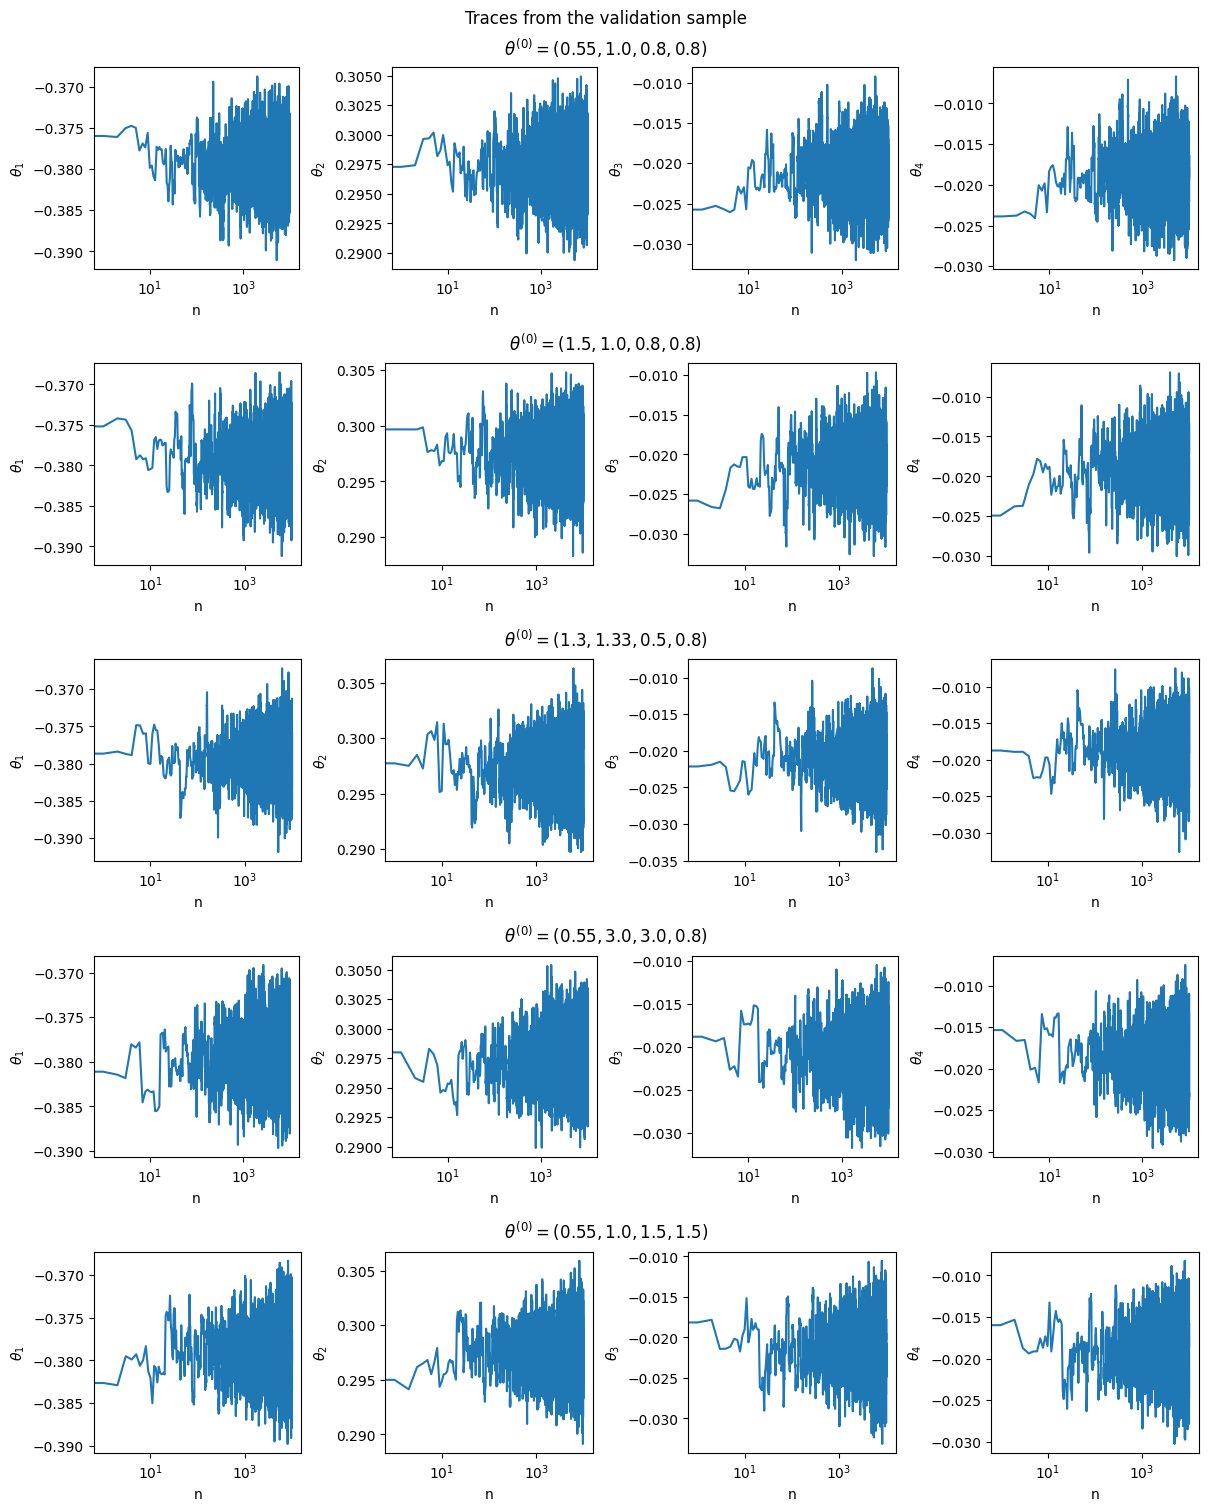

In [42]:
fig = plot_traces(validation_hmc_samples, titles=titles, var_labels=var_labels);
fig.suptitle('Traces from the validation sample');

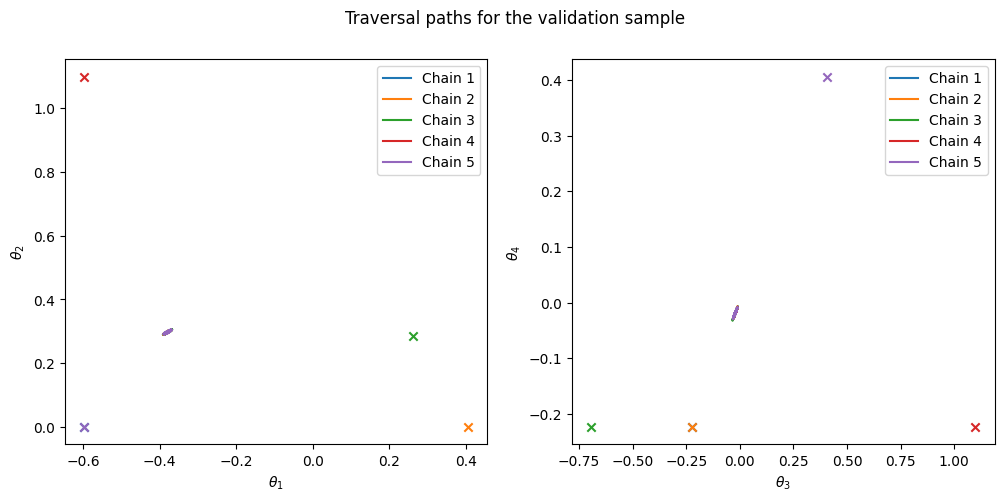

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Traversal paths for the validation sample');
plot_paths(validation_hmc_samples, np.log(theta_inits), idx1=0, idx2=1, ax=axs[0], label1='$\\theta_1$', label2='$\\theta_2$');
plot_paths(validation_hmc_samples, np.log(theta_inits), idx1=2, idx2=3, ax=axs[1], label1='$\\theta_3$', label2='$\\theta_4$');

In [44]:
validation_sample = np.concatenate(validation_hmc_samples, axis=0)

# Sensitivity analysis

## Forward sensitivity equations

Given a system of ODEs of the form:
$$\frac{du_r}{dt} = F_q(t, u_1, \dots, u_q; x),\qquad r=1,\dots,q,$$
the sensitivities can be found by solving forward sensitivity equations (this is equation (35) in the Supplementary Material):
$$\frac{d}{dt}\left(\frac{\partial u_r}{\partial x_s}\right) = \frac{dF_r}{dx_s} + \sum_{l=1}^q \frac{\partial F_r}{\partial u_l} \frac{\partial u_l}{\partial x_s}$$
with initial conditions
$$\frac{\partial u_r}{\partial x_s}(0) = 0.$$

For the Lotka-Volterra model, the forward sensitivity equations are:
$$\begin{split}
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_1}\right) &= u_1 + (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_1} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_1}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_2}\right) &= - u_1 u_2 + (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_2} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_2}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_3}\right) &= (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_3} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_3}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_4}\right) &= (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_4} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_4}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_1}\right) &= \theta_4 u_2 \frac{\partial u_1}{\partial \theta_1} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_1}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_2}\right) &= \theta_4 u_2 \frac{\partial u_1}{\partial \theta_2} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_2}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_3}\right) &= -u_2 + \theta_4 u_2 \frac{\partial u_1}{\partial \theta_3} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_3}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_4}\right) &= u_1 u_2 + \theta_4 u_2 \frac{\partial u_1}{\partial \theta_4} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_4}. \\
\end{split}$$

Denoting $w_1 = \frac{\partial u_1}{\partial \theta_1}$, $w_2 = \frac{\partial u_1}{\partial \theta_2}$, $w_3 = \frac{\partial u_1}{\partial \theta_3}$, $w_4 = \frac{\partial u_1}{\partial \theta_4}$ and $w_5 = \frac{\partial u_2}{\partial \theta_1}$, $w_6 = \frac{\partial u_2}{\partial \theta_2}$, $w_7 = \frac{\partial u_2}{\partial \theta_3}$, $w_8 = \frac{\partial u_2}{\partial \theta_4}$, we have the following additional equations:
$$\begin{split}
\frac{dw_1}{dt} &= u_1 + (\theta_1 - \theta_2 u_2) w_1 - \theta_2 u_1 w_5, \\
\frac{dw_2}{dt} &= - u_1 u_2 + (\theta_1 - \theta_2 u_2) w_2 - \theta_2 u_1 w_6, \\
\frac{dw_3}{dt} &= (\theta_1 - \theta_2 u_2) w_3 - \theta_2 u_1 w_7, \\
\frac{dw_4}{dt} &= (\theta_1 - \theta_2 u_2) w_4 - \theta_2 u_1 w_8, \\
\frac{dw_5}{dt} &= \theta_4 u_2 w_1 + (\theta_4 u_1 - \theta_3) w_5, \\
\frac{dw_6}{dt} &= \theta_4 u_2 w_2 + (\theta_4 u_1 - \theta_3) w_6, \\
\frac{dw_7}{dt} &= -u_2 + \theta_4 u_2 w_3 + (\theta_4 u_1 - \theta_3) w_7, \\
\frac{dw_8}{dt} &= u_1 u_2 + \theta_4 u_2 w_4 + (\theta_4 u_1 - \theta_3) w_8. \\
\end{split}$$

In [45]:
def lotka_volterra_sensitivity(t, uw, theta):
    theta1, theta2, theta3, theta4 = theta
    u1, u2, w1, w2, w3, w4, w5, w6, w7, w8 = uw
    return [
        # model equations
        theta1 * u1 - theta2 * u1 * u2,
        theta4 * u1 * u2 - theta3 * u2,
        # sensitivities
        u1 + (theta1 - theta2 * u2) * w1 - theta2 * u1 * w5,
        -u1 * u2 + (theta1 - theta2 * u2) * w2 - theta2 * u1 * w6,
        (theta1 - theta2 * u2) * w3 - theta2 * u1 * w7,
        (theta1 - theta2 * u2) * w4 - theta2 * u1 * w8,
        theta4 * u2 * w1 + (theta4 * u1 - theta3) * w5,
        theta4 * u2 * w2 + (theta4 * u1 - theta3) * w6,
        -u2 + theta4 * u2 * w3 + (theta4 * u1 - theta3) * w7,
        u1 * u2 + theta4 * u2 * w4 + (theta4 * u1 - theta3) * w8,
    ]

In [46]:
uw_init = np.concatenate([np.array(u_init), np.zeros(d * q)])

In [47]:
%%time
sol = solve_ivp(lotka_volterra_sensitivity, t_span, uw_init, args=(theta,), dense_output=True)
sensitivity_forward = sol.sol(t).T

CPU times: user 9.2 ms, sys: 3.82 ms, total: 13 ms
Wall time: 12.1 ms


Plot the solution again:

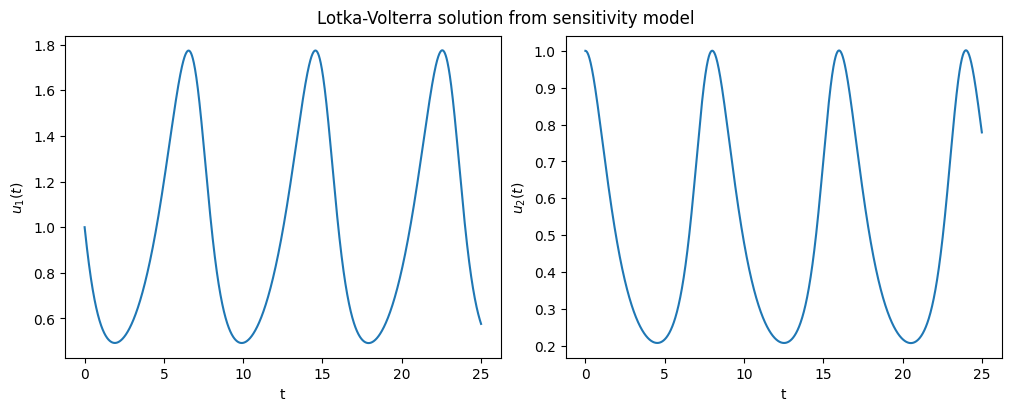

In [48]:
fig, axs = plt.subplots(1, q, figsize=(10, 4), constrained_layout=True)
fig.suptitle('Lotka-Volterra solution from sensitivity model');
for i in range(q):
    axs[i].plot(t, sensitivity_forward[:, i]);
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

Plot the sensitivities:

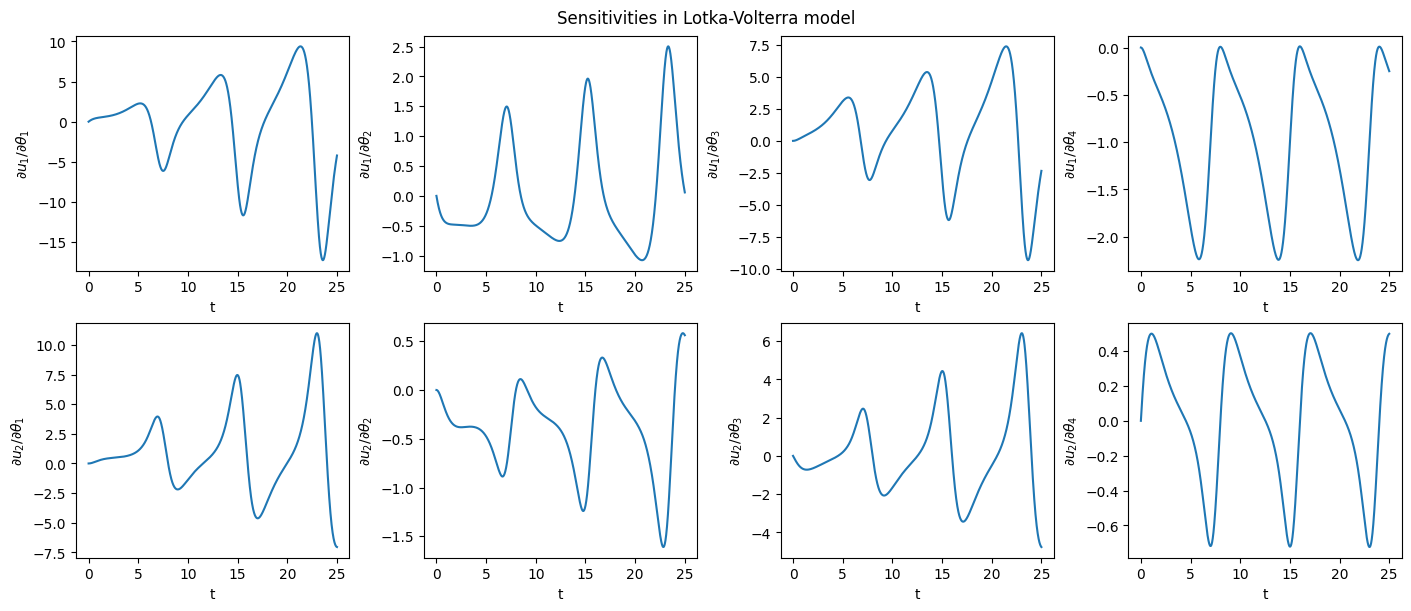

In [49]:
fig, axs = plt.subplots(q, d, figsize=(14, 6), constrained_layout=True)
fig.suptitle('Sensitivities in Lotka-Volterra model');
for i in range(q):
    for j in range(d):
        axs[i][j].plot(t, sensitivity_forward[:, q + i * d + j]);
        axs[i][j].set_xlabel('t');
        axs[i][j].set_ylabel(f'$\\partial u_{{{i + 1}}} / \\partial \\theta_{{{j + 1}}}$');

## Numerical Jacobian calculation

Redefine the function since ``jax.experimental.ode.odeint`` passes the state variable in the first argument and time in the second argument:

In [50]:
def lotka_volterra2(u, t, theta):
    return [
        theta[0] * u[0] - theta[1] * u[0] * u[1],
        theta[3] * u[0] * u[1] - theta[2] * u[1],
    ]

In [51]:
def solve_lotka_volterra2(theta):
    return odeint(lotka_volterra2, jnp.array(u_init), jnp.array(t), jnp.array(theta))

In [52]:
sol2 = solve_lotka_volterra2(theta)

Plot the solution first:

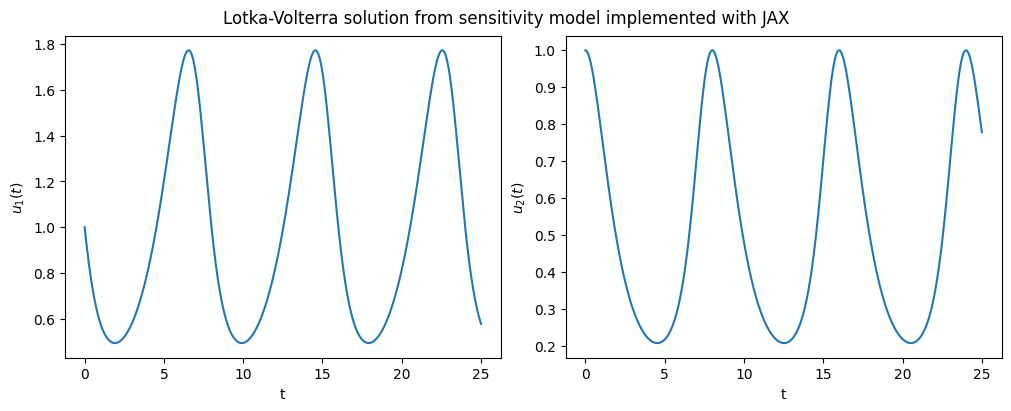

In [53]:
fig, axs = plt.subplots(1, q, figsize=(10, 4), constrained_layout=True)
fig.suptitle('Lotka-Volterra solution from sensitivity model implemented with JAX');
for i in range(q):
    axs[i].plot(t, sol2[:, i]);
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

Calculate the sensitivities:

In [54]:
%%time
sensitivity_jax = jacobian(solve_lotka_volterra2)(theta)

CPU times: user 30.4 s, sys: 746 ms, total: 31.2 s
Wall time: 28 s


We confirm that the numerical method agrees with the results from forward sensitivity equations:

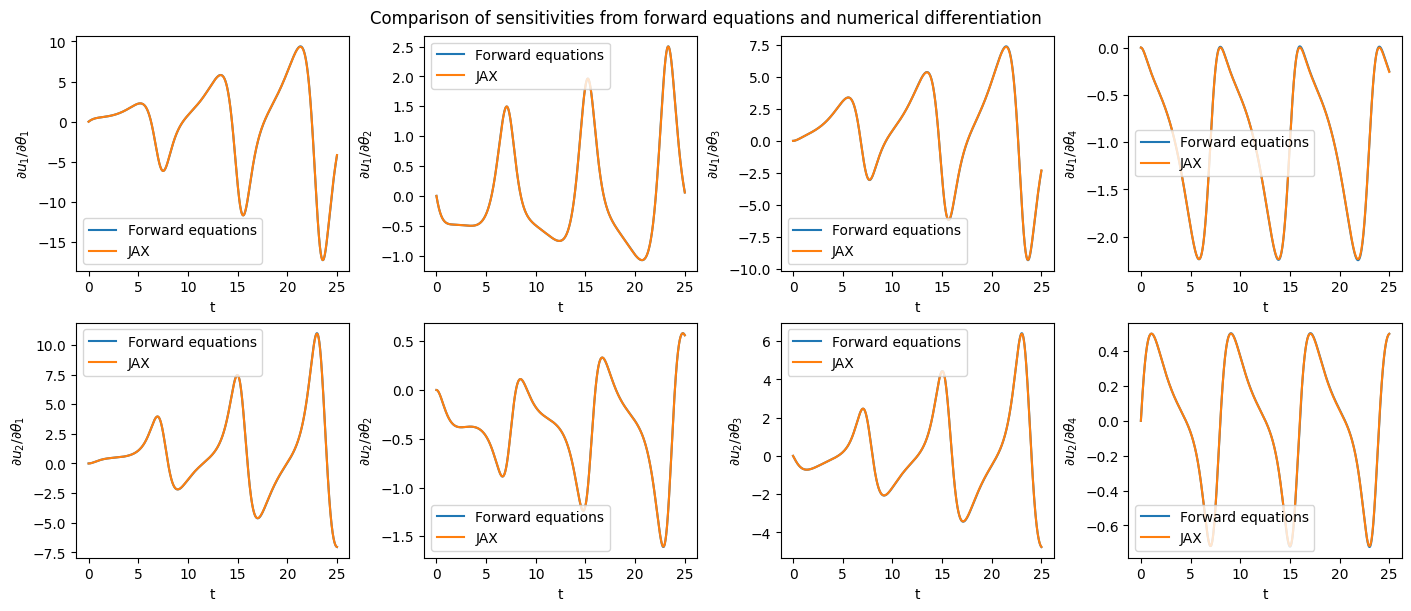

In [55]:
fig, axs = plt.subplots(q, d, figsize=(14, 6), constrained_layout=True)
fig.suptitle('Comparison of sensitivities from forward equations and numerical differentiation');
for i in range(2):
    for j in range(d):
        axs[i][j].plot(t, sensitivity_forward[:, 2 + i * d + j], label='Forward equations');
        axs[i][j].plot(t, sensitivity_jax[j][:, i], label='JAX');
        axs[i][j].set_xlabel('t');
        axs[i][j].set_ylabel(f'$\\partial u_{{{i + 1}}} / \\partial \\theta_{{{j + 1}}}$');
        axs[i][j].legend();

## Calculating the gradient of the log-posterior

The Stein Thinning methog requires the gradient of the log-posterior $\nabla \log p$ as input. Below we follow section S3 of the Supplementary Material to derive it.

Since $p(x) \propto \mathcal{L}(x) \pi(x)$, we have 
$$\nabla \log p(x) = \nabla \log \mathcal{L}(x) + \nabla \log \pi(x).$$
Assuming independent errors in observations yields
$$\mathcal{L}(x) = \prod_{i=1}^N \phi_i(u(t_i)),$$
and thus 
$$
\frac{\partial}{\partial x_s} \log \mathcal{L}(x) 
= \sum_{i=1}^N \frac{\partial}{\partial x_s} \log \phi_i(u(t_i))
= \sum_{i=1}^N \sum_{r=1}^q \frac{\partial}{\partial u_r} (\log \phi_i) \frac{\partial u_r}{\partial x_s},
$$
which can be written in matrix notation as
$$(\nabla \log \mathcal{L})(x) = \sum_{i=1}^N \left(\frac{\partial u}{\partial x}\right)^T (t_i) (\nabla \log \phi_i)(u(t_i)),$$
where
$$\left(\frac{\partial u}{\partial x}\right)_{r,s} = \frac{\partial u_r}{\partial x_s}$$
is the Jacobian matrix of sensitivities, as obtained earlier.

Note that this does not match the expression provided on page 16 of the Supplementary Material:
$$(\nabla \log \mathcal{L})(x) = -\sum_{i=1}^N \frac{\partial u}{\partial x}(t_i) (\nabla \log \phi_i)(u(t_i)),$$
where the Jacobian is not transposed and there is a minus sign in front of the expression.

For a multivariate normal distribution of the errors:
$$\phi_i(u(t_i)) \propto \exp\left( -\frac{1}{2} (y_i - u(t_i))^T C^{-1} (y_i - u(t_i)) \right)$$
we obtain
$$(\nabla \log \phi_i)(u(t_i)) = C^{-1}(y_i - u(t_i)).$$

We assume independent standard normal priors for all parameters, therefore
$$\pi(x) = \prod_{i=1}^d \pi_i(x_i) \propto \exp\left(-\frac{1}{2}\sum_{i=1}^d x_i^2\right)$$
and
$$\nabla \log \pi(x) = -x.$$

We calculate the gradient of the log-likelihood from the Jacobian obtained previosly:

In [56]:
# reshape the Jacobian so it can be multiplied by the gradient of log phi
J = sensitivity_forward[:, q:].reshape(len(t), -1, q, order='F')
J.shape

(2400, 4, 2)

In [57]:
# calculate the gradient of log phi and reshape it
grad_log_phi = (inv(C) @ (y - sensitivity_forward[:, :q]).T).T[:, :, np.newaxis]
grad_log_phi.shape

(2400, 2, 1)

In [58]:
grad_log_lik = np.sum(np.squeeze(J @ grad_log_phi), axis=0)
grad_log_lik

array([ 909.8283571 , -161.34819546,  313.24871815,   71.0105305 ])

Now put the calculation into a function so we can use it later:

In [59]:
def grad_log_likelihood(theta):
    """Solve the system of ODEs and calculate the log-likelihood"""
    sol = solve_ivp(lotka_volterra_sensitivity, t_span, uw_init, args=(theta,), dense_output=True)
    sensitivity_forward = sol.sol(t).T
    J = sensitivity_forward[:, q:].reshape(len(t), -1, q, order='F')
    grad_log_phi = (inv(C) @ (y - sensitivity_forward[:, :q]).T).T[:, :, np.newaxis]
    return np.sum(np.squeeze(J @ grad_log_phi), axis=0)

In [60]:
%%time
grad_log_likelihood(theta)

CPU times: user 18.7 ms, sys: 0 ns, total: 18.7 ms
Wall time: 17.5 ms


array([ 909.8283571 , -161.34819546,  313.24871815,   71.0105305 ])

We check the numbers against the numerical gradient:

In [61]:
def grad_log_likelihood_jax(theta):
    import jax.scipy.stats as jstats
    def log_likelihood(theta):
        sol = odeint(lotka_volterra2, jnp.array(u_init), jnp.array(t), jnp.array(theta))
        return jnp.sum(jstats.multivariate_normal.logpdf(jnp.array(y) - sol, mean=jnp.array(means), cov=jnp.array(C)))
    return jacobian(log_likelihood)(theta)

In [62]:
%%time
grad_log_likelihood_jax(theta)

CPU times: user 2.38 s, sys: 96.6 ms, total: 2.48 s
Wall time: 2.35 s


[Array(872.54626, dtype=float32, weak_type=True),
 Array(-144.05716, dtype=float32, weak_type=True),
 Array(307.38287, dtype=float32, weak_type=True),
 Array(64.167496, dtype=float32, weak_type=True)]

We use the gradient calculation based on solving forward sensitivity equations in what follows.

In [63]:
def grad_log_posterior(theta):
    return grad_log_likelihood(theta) - theta

In [64]:
grad_log_posterior(theta)

array([ 909.1583571 , -162.67819546,  312.24871815,   70.0105305 ])

## Parallel calculation of gradients

We note that calculating gradients after a MCMC run is what is called "embarrassingly parallelisable" and the time required for this step can be effectively eliminated given sufficient computational resources. This is in contrast to the MCMC run itself, which is inherently sequential.

Here we demonstrate how the popular package ``Dask`` can be used to parallelise this computation across cores of a local machine.

See the notebook in ``examples/Dask_AWS.ipynb`` for a comparison between sequential calculation, parallel computation locally and on AWS.

We can save time by calculating the gradients for unique samples only:

A helper function to calculate gradients using unique values only:

In [65]:
def parallelise_for_unique(func, sample, row_chunk_size=200):
    """Calculate gradients for samples"""
    # we can save time by calculating gradients for unique samples only
    unique_samples, inverse_index = np.unique(sample, axis=0, return_inverse=True)
    res = apply_along_axis_parallel(func, 1, unique_samples, row_chunk_size, client)
    return res[inverse_index]

Calculate the gradients for the random-walk samples:

In [66]:
%%time
rw_grads = map_cached(
    lambda item: parallelise_for_unique(grad_log_posterior, np.exp(item[1])),
    enumerate(rw_samples),
    lambda item: generated_data_dir / f'rw_gradient_{item[0]}_seed_{rw_seed}.csv',
    recalculate=recalculate,
    save=save_rw_gradients,
)

CPU times: user 11.2 s, sys: 1.02 s, total: 12.2 s
Wall time: 23.5 s


Calculate the gradients for HMC samples:

In [67]:
%%time
hmc_grads = map_cached(
    lambda item: parallelise_for_unique(grad_log_posterior, np.exp(item[1])),
    enumerate(hmc_samples),
    lambda item: generated_data_dir / f'hmc_gradient_{item[0]}_seed_{hmc_seed}.csv',
    recalculate=recalculate,
    save=save_hmc_gradients,
)

CPU times: user 271 ms, sys: 12.1 ms, total: 283 ms
Wall time: 466 ms


# Apply Stein thinning

### Random-walk sample

In [68]:
n_points_thinned = 20

In [69]:
%%time
rw_thinned_idx = [
    thin(np.exp(rw_samples[i]), rw_grads[i], n_points_thinned, preconditioner='med') for i in range(len(rw_samples))
]

CPU times: user 21.9 s, sys: 21.7 s, total: 43.6 s
Wall time: 12 s


This reproduces the results shown in Figure S20 in the Supplementary Material:

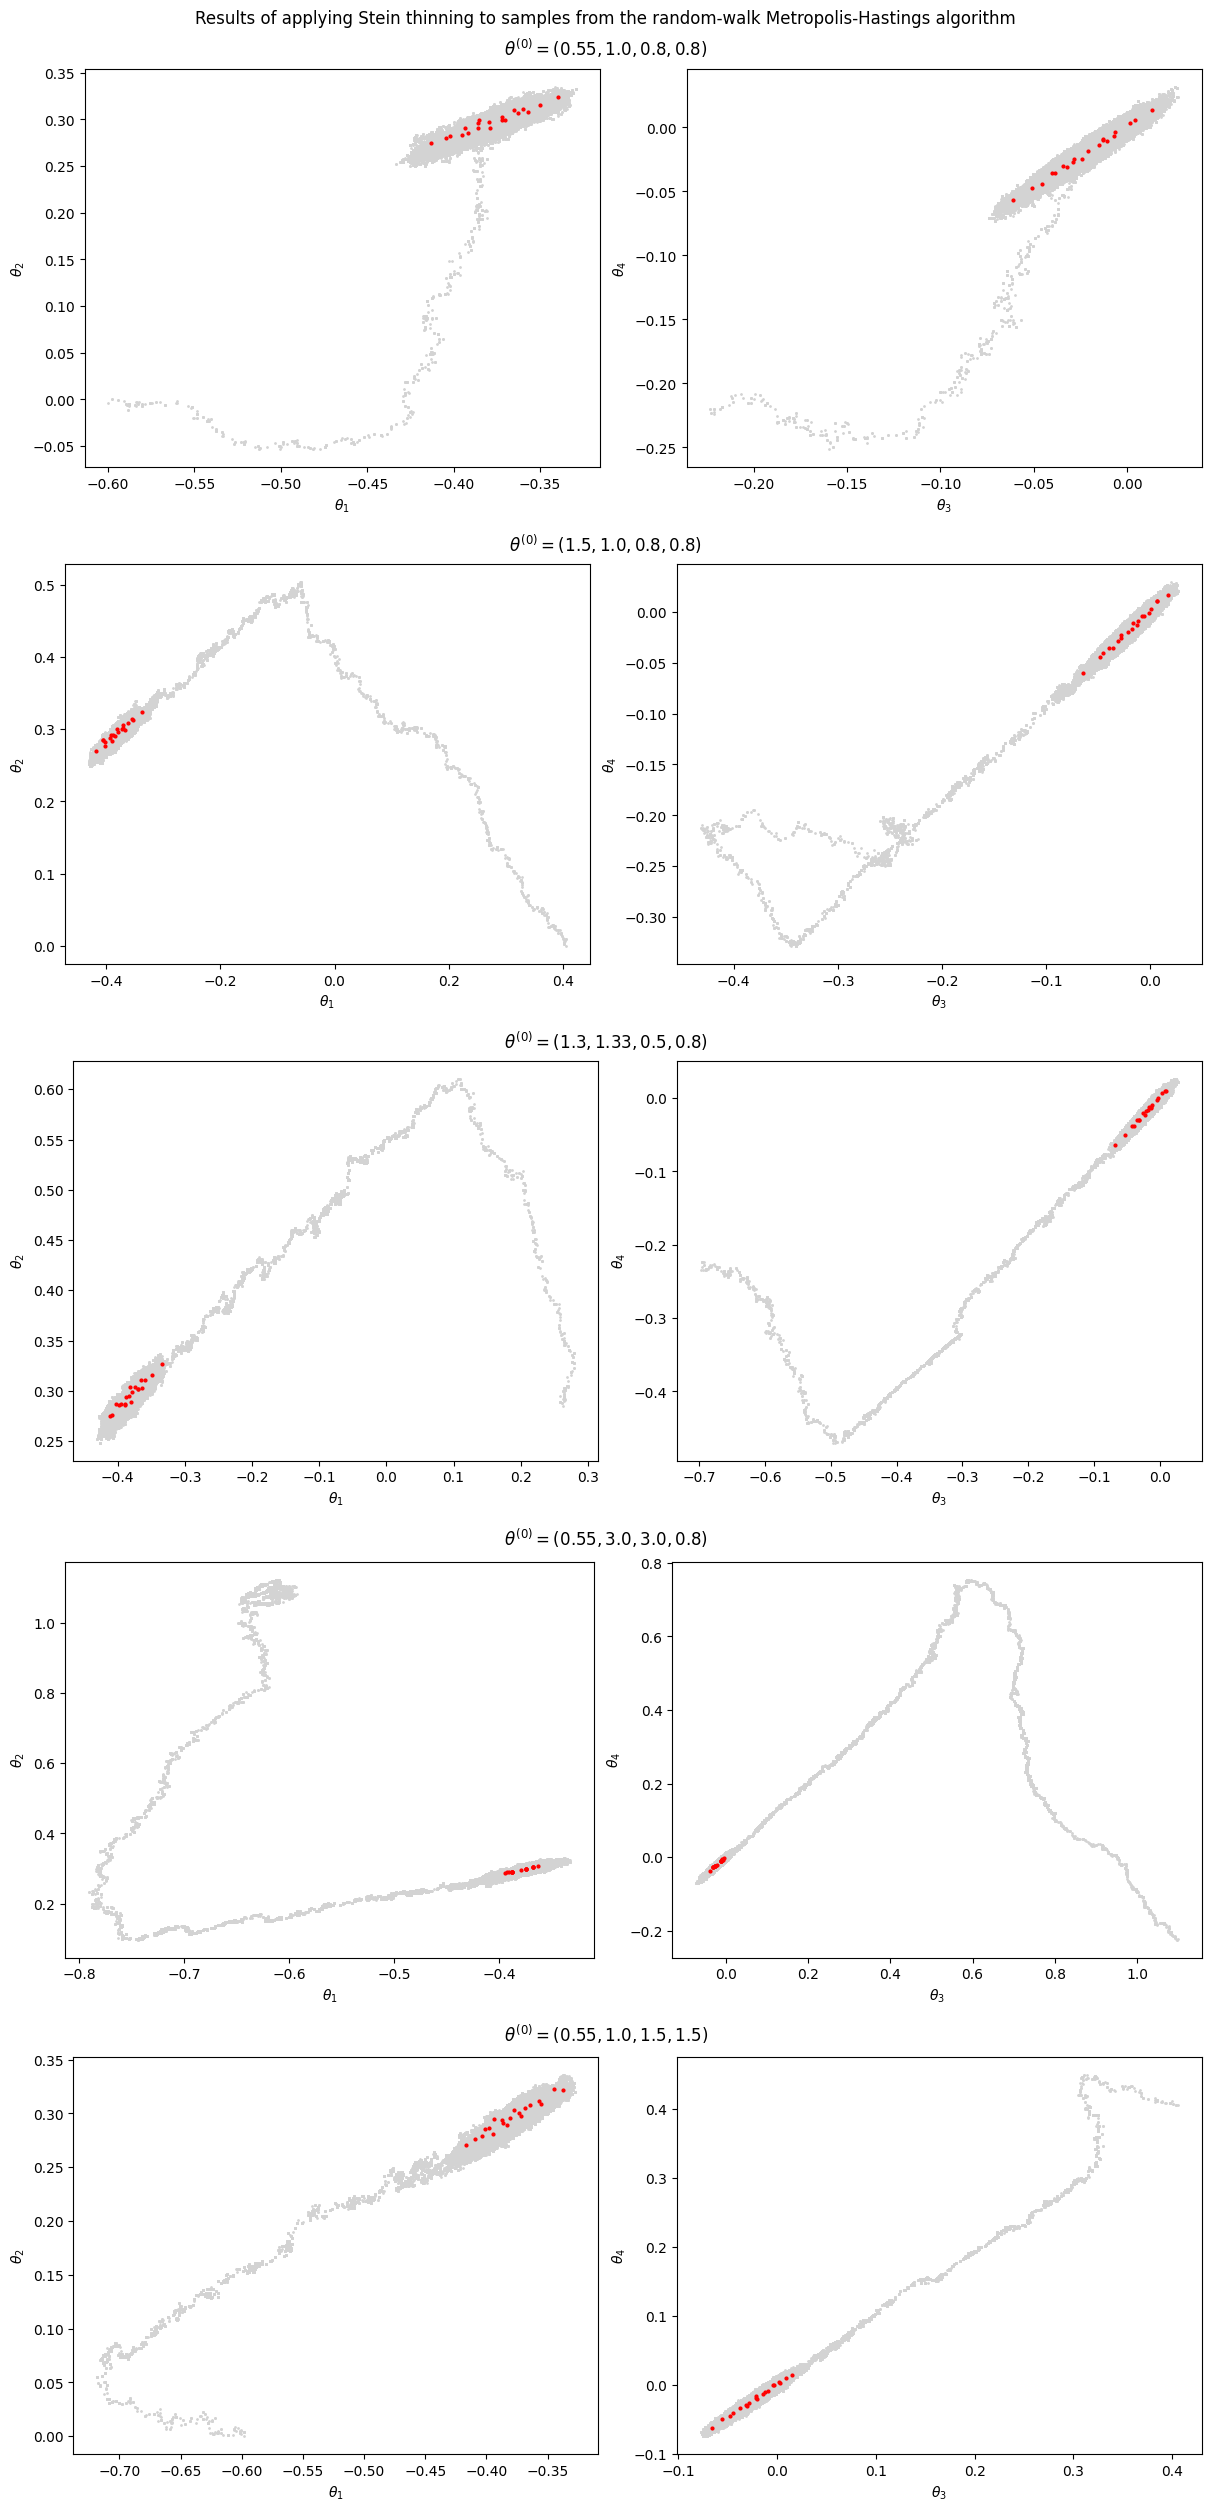

In [70]:
fig = plot_sample_thinned(rw_samples, rw_thinned_idx, titles, var_labels);
fig.suptitle('Results of applying Stein thinning to samples from the random-walk Metropolis-Hastings algorithm');

### HMC sample

In [71]:
hmc_thinned_idx = [
    thin(np.exp(hmc_samples[i]), hmc_grads[i], n_points_thinned, preconditioner='med') for i in range(len(hmc_samples))
]

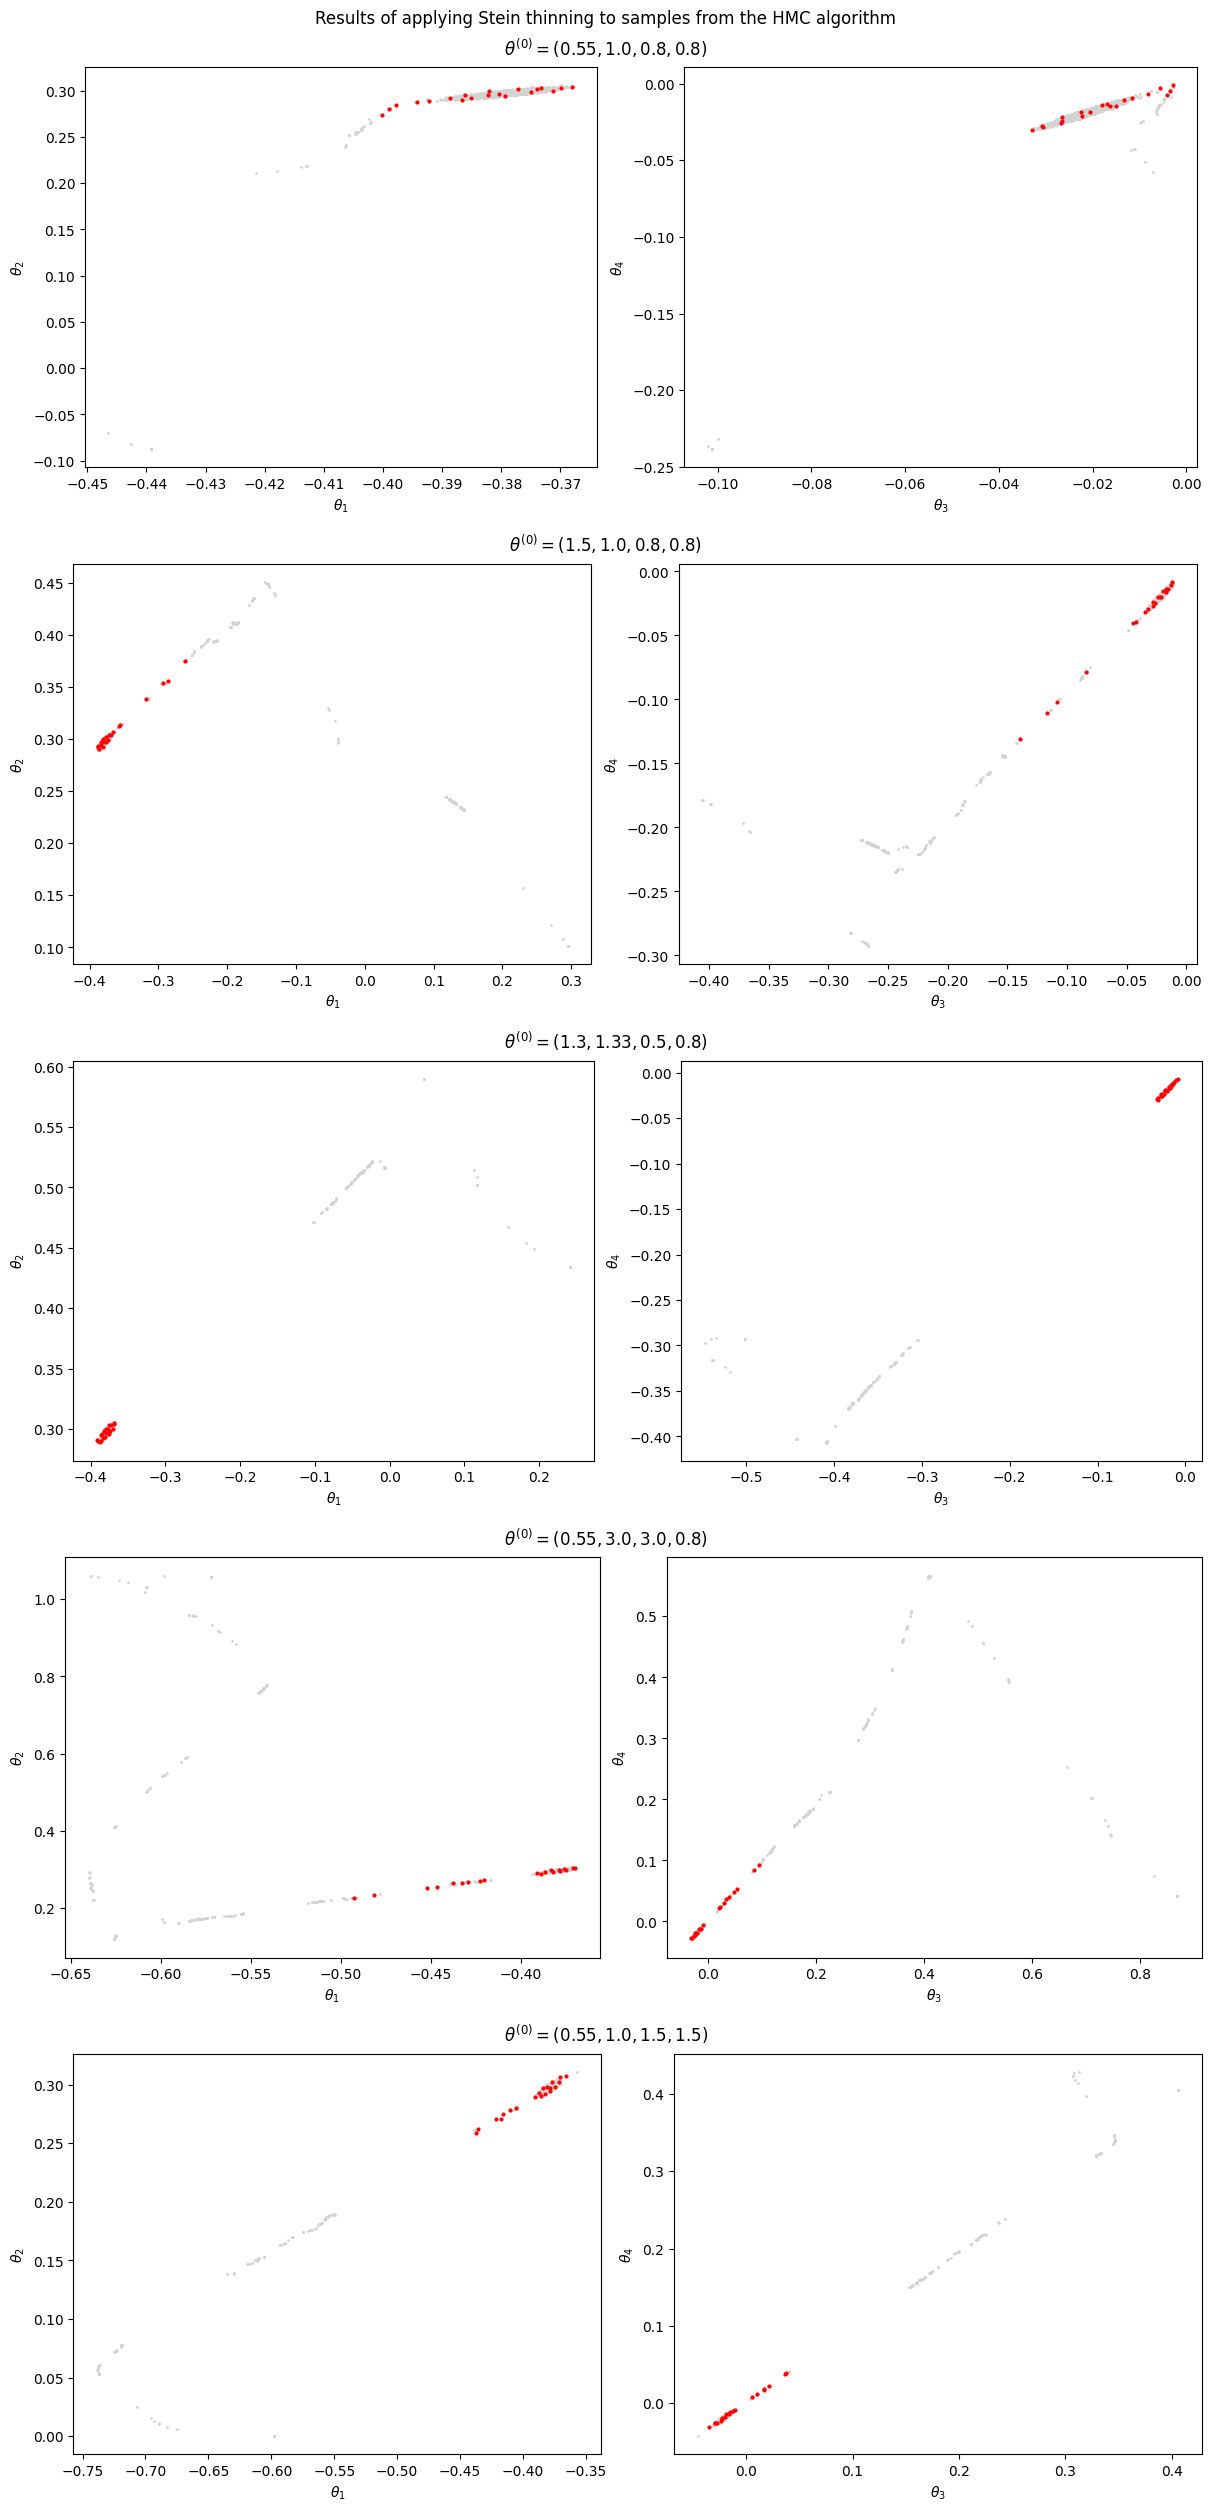

In [72]:
fig = plot_sample_thinned(hmc_samples, hmc_thinned_idx, titles, var_labels);
fig.suptitle('Results of applying Stein thinning to samples from the HMC algorithm');

# Gradient-free Stein thinning

We recalculate the (unnormalised) log target density for all samples. Note that in principle we could have stored it during the MCMC run rather than recalculating it.

In [73]:
%%time
rw_log_p = map_cached(
    lambda item: parallelise_for_unique(log_target_density, item[1]),
    enumerate(rw_samples),
    lambda item: generated_data_dir / f'rw_log_p_{item[0]}_seed_{rw_seed}.csv',
    recalculate=recalculate,
    save=save_rw_log_p,
)

CPU times: user 4.62 s, sys: 214 ms, total: 4.84 s
Wall time: 5.13 s


In [74]:
%%time
hmc_log_p = map_cached(
    lambda item: parallelise_for_unique(log_target_density, item[1]),
    enumerate(hmc_samples),
    lambda item: generated_data_dir / f'hmc_log_p_{item[0]}_seed_{hmc_seed}.csv',
    recalculate=recalculate,
    save=save_hmc_log_p,
)

CPU times: user 128 ms, sys: 4.62 ms, total: 133 ms
Wall time: 278 ms


In [75]:
def thin_gf_kde(sample, log_p, thinned_size):
    kde = jgaussian_kde(sample[::1000].T, bw_method='silverman')
    log_q = np.array(kde.logpdf(sample.T))
    kde_grad = grad(lambda x: kde.logpdf(x)[0])
    gradient_q = np.array(jnp.apply_along_axis(kde_grad, 1, sample))
    return thin_gf(sample, log_p, log_q, gradient_q, thinned_size)

In [76]:
%%time
rw_gf_kde_idx = [
    thin_gf_kde(rw_samples[i], rw_log_p[i], n_points_thinned) for i in range(len(rw_samples))
]

/home/artem/git/stein_thinning/stein_thinning/thinning.py:118: RuntimeWarning: overflow encountered in exp
  np.exp(log_q[ind1] - log_p[ind1] + log_q[ind2] - log_p[ind2]) *
/home/artem/git/stein_thinning/stein_thinning/thinning.py:118: RuntimeWarning: overflow encountered in multiply
  np.exp(log_q[ind1] - log_p[ind1] + log_q[ind2] - log_p[ind2]) *
/home/artem/git/stein_thinning/stein_thinning/thinning.py:40: RuntimeWarning: invalid value encountered in add
  k0 += 2 * integrand(slice(None), [idx[i - 1]])


CPU times: user 55.6 s, sys: 33 s, total: 1min 28s
Wall time: 32.3 s


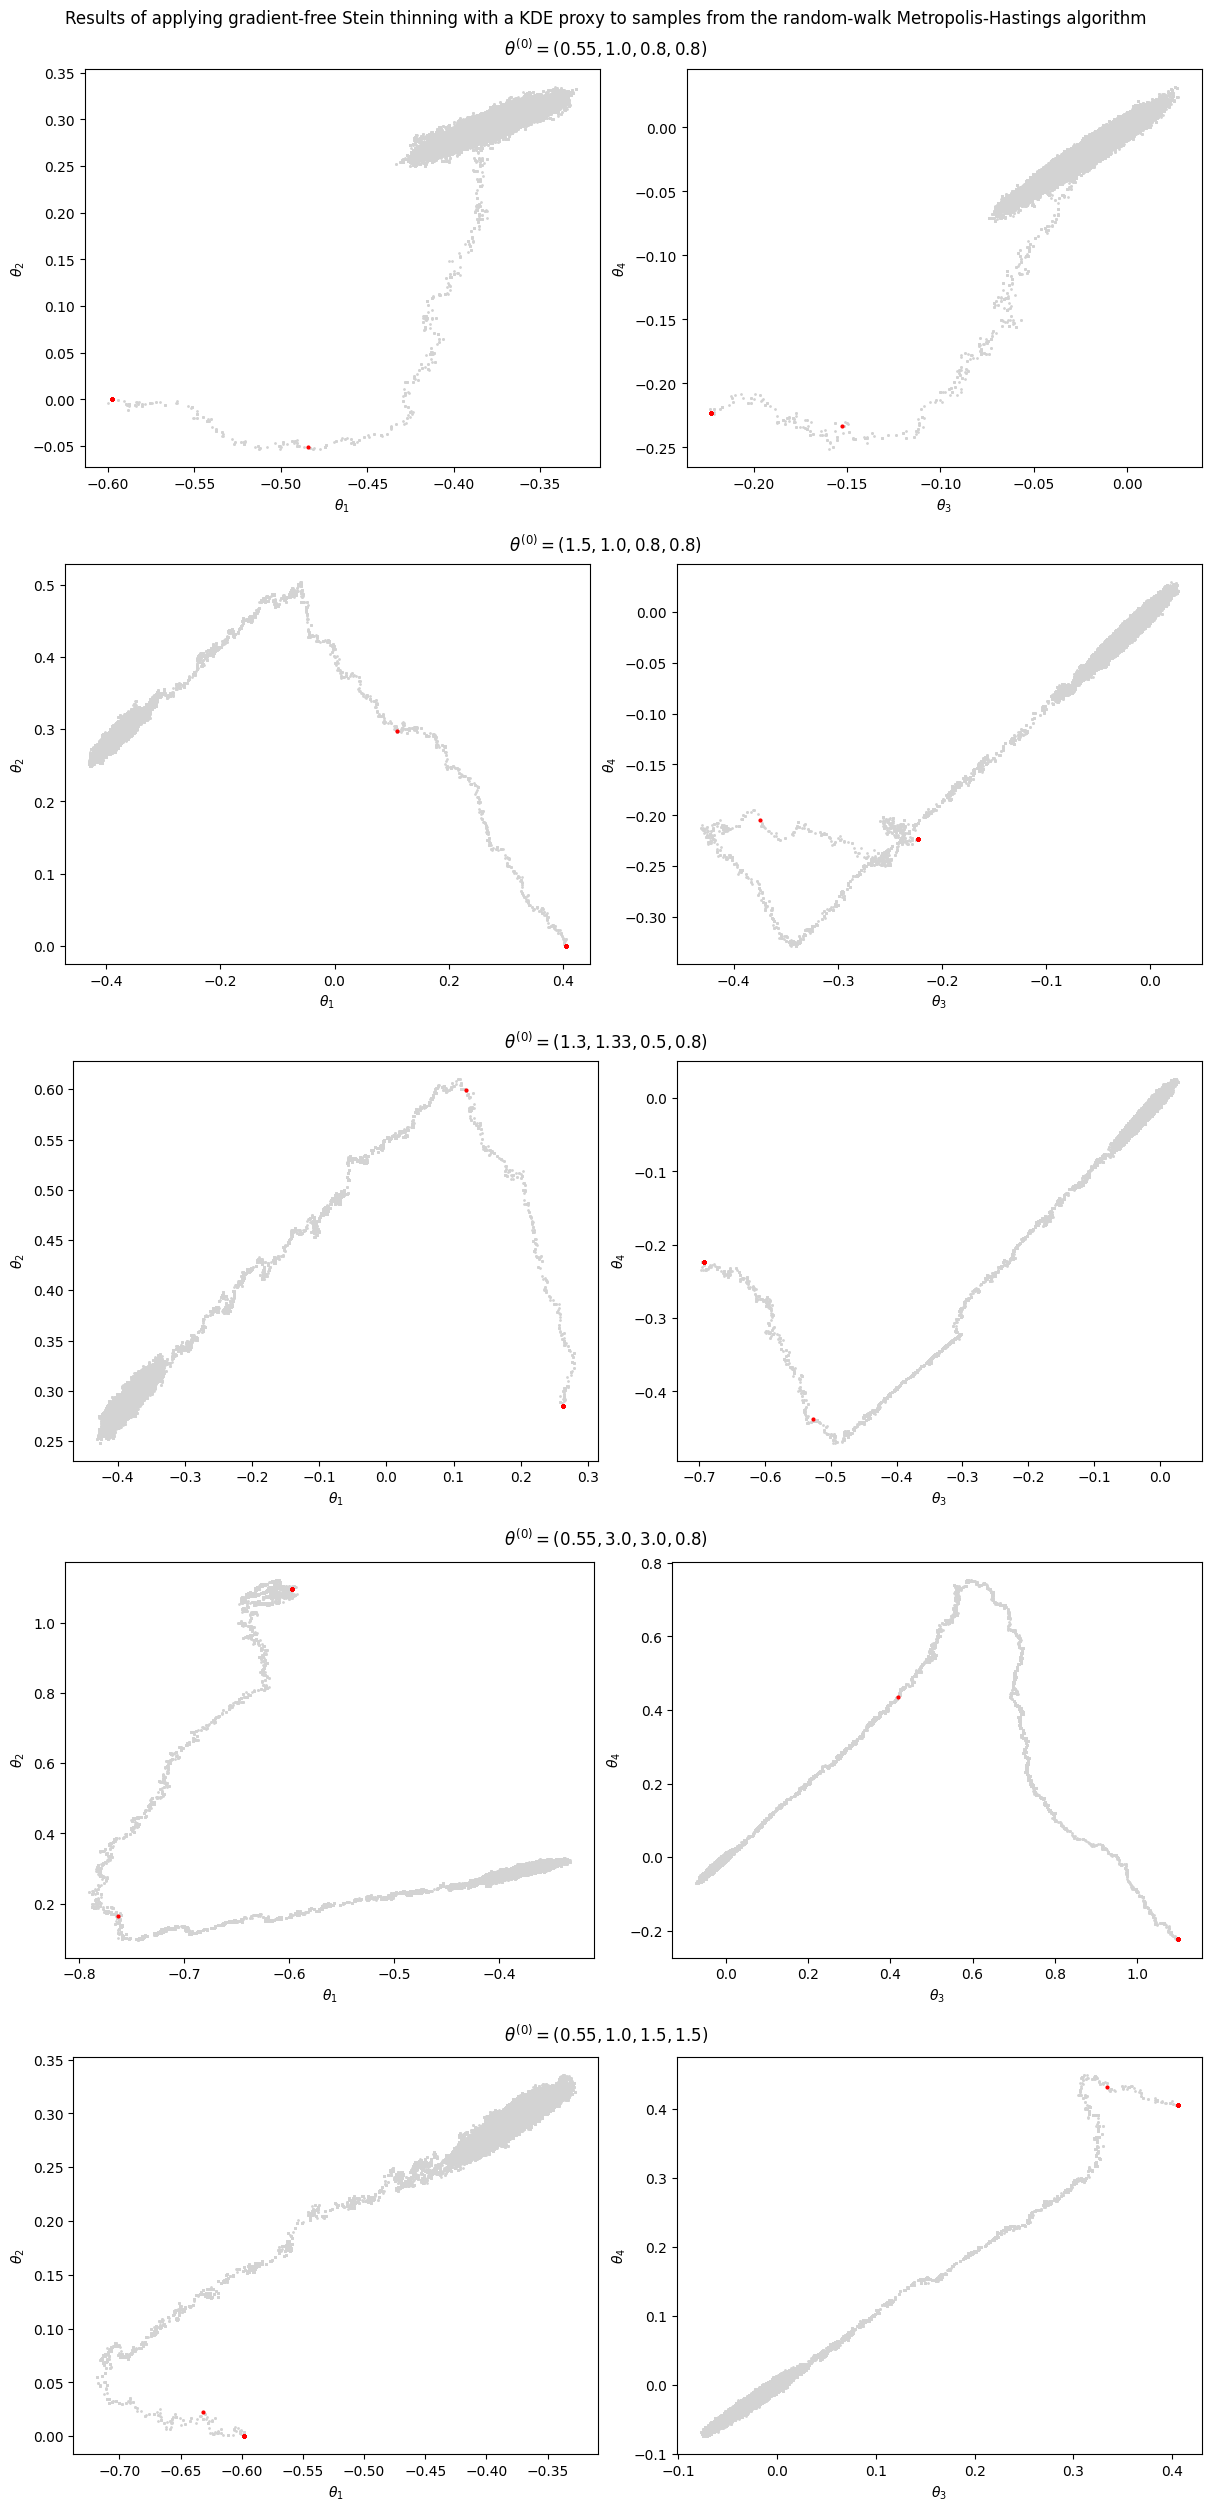

In [77]:
fig = plot_sample_thinned(rw_samples, rw_gf_kde_idx, titles, var_labels);
fig.suptitle('Results of applying gradient-free Stein thinning with a KDE proxy to samples from the random-walk Metropolis-Hastings algorithm');

# Naive thinning

The baseline for comparison is the naive thinning approach where we retain each i-th element of the sample.

In [78]:
def naive_thin(sample_size, thinned_size):
    return np.linspace(0, sample_size - 1, thinned_size).astype(int)

In [79]:
rw_naive_idx = [
    naive_thin(rw_sample.shape[0], n_points_thinned) for rw_sample in rw_samples
]

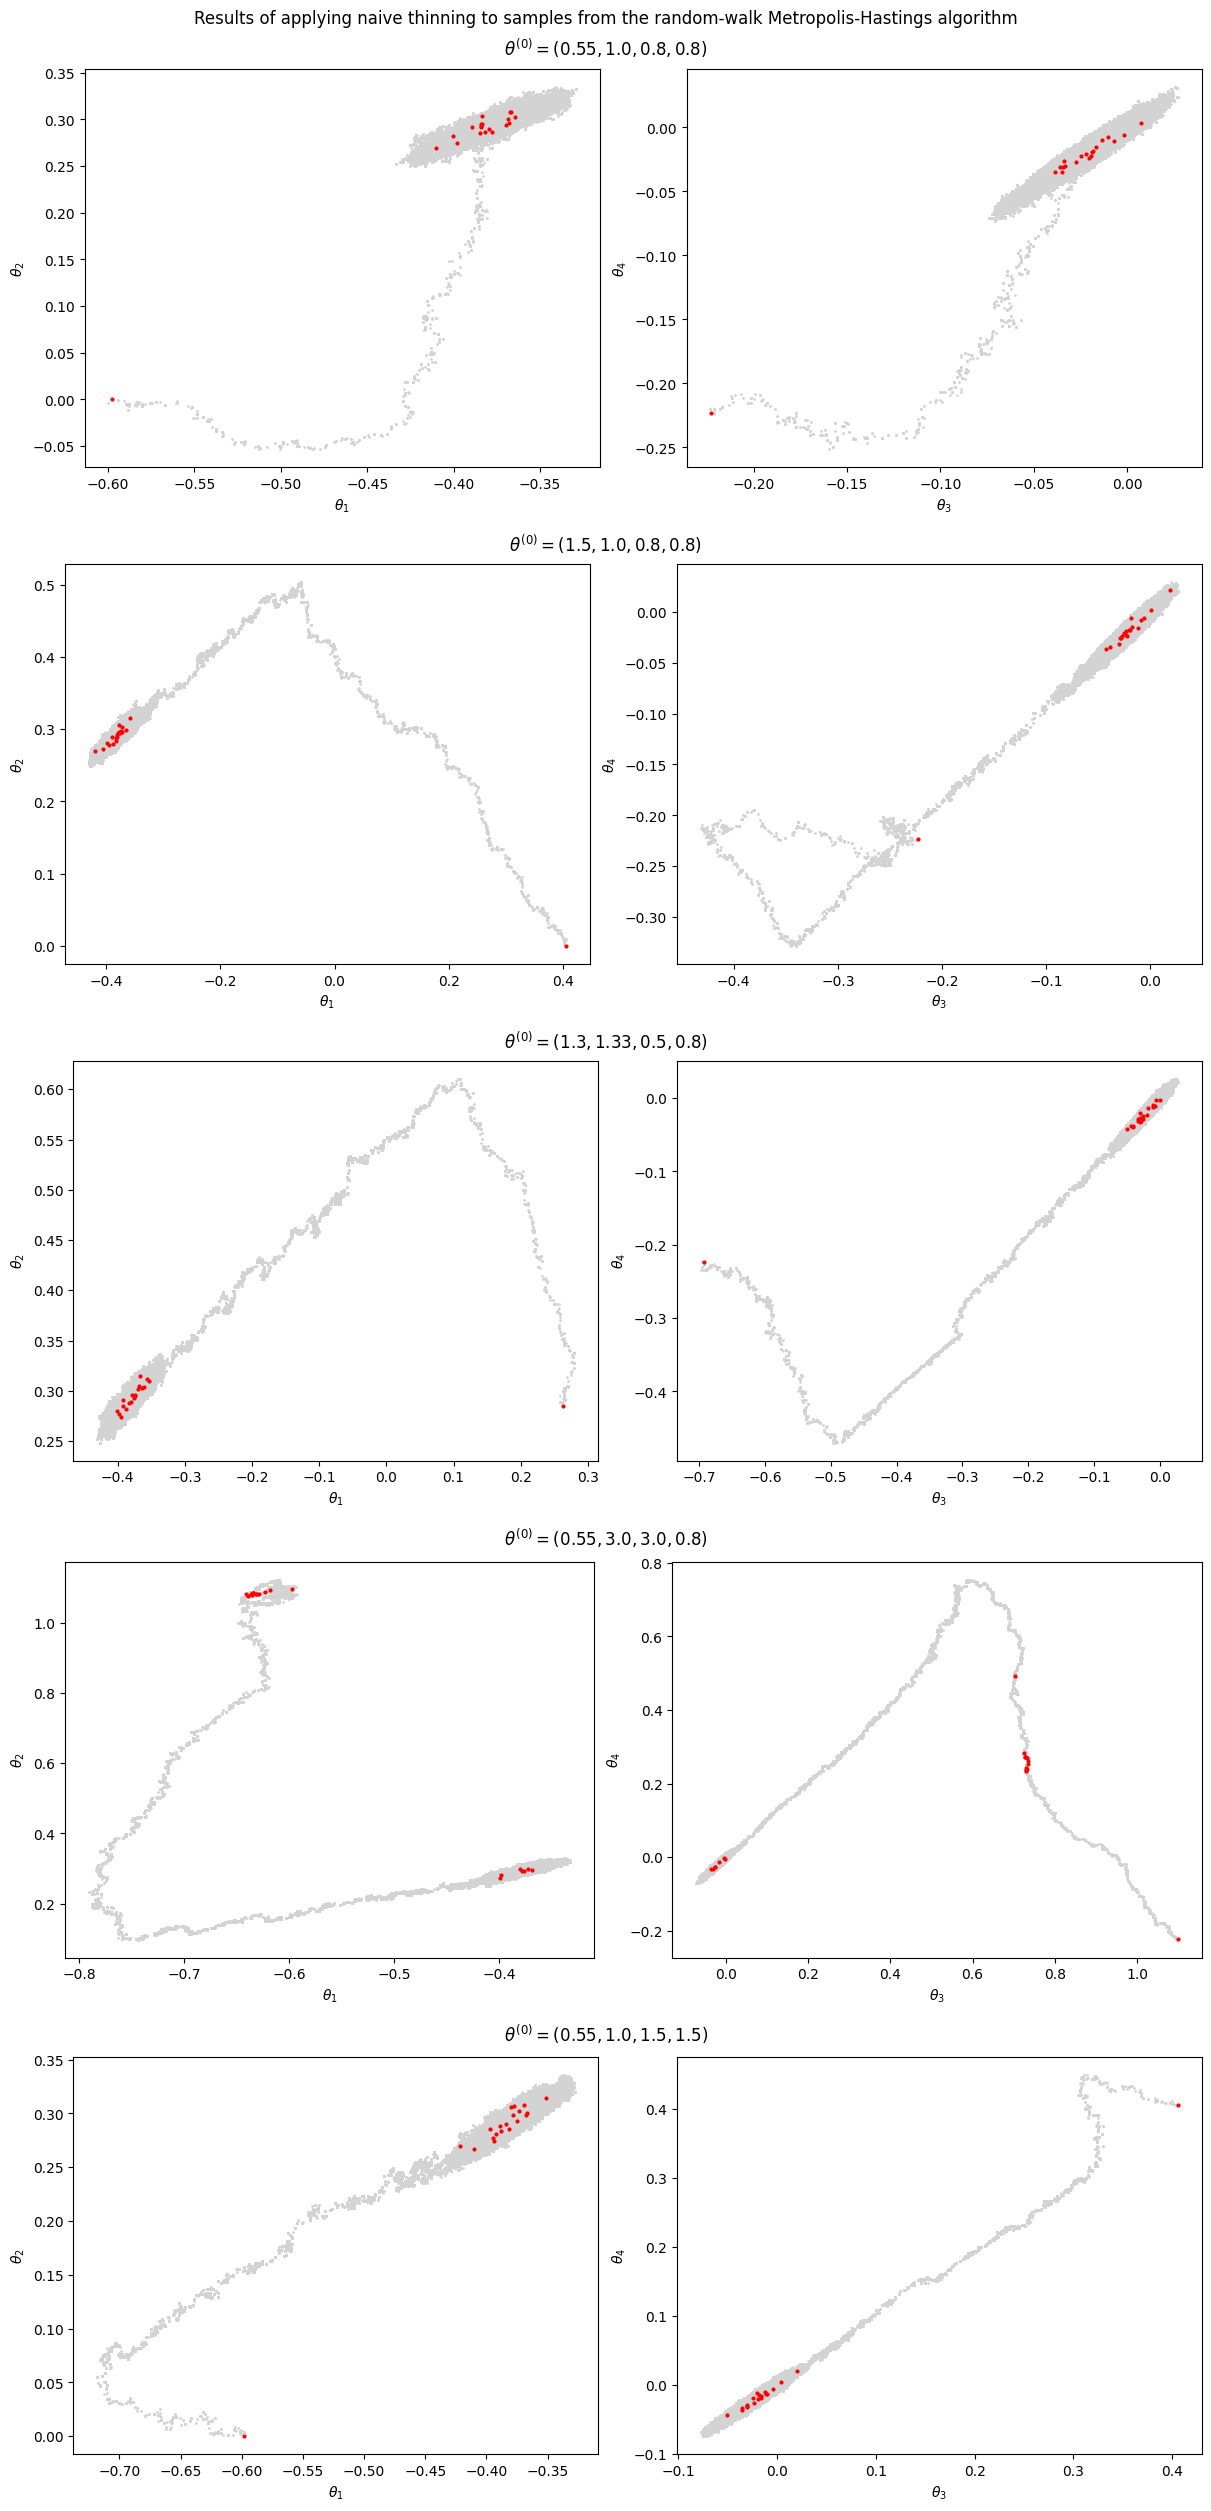

In [80]:
fig = plot_sample_thinned(rw_samples, rw_naive_idx, titles, var_labels);
fig.suptitle('Results of applying naive thinning to samples from the random-walk Metropolis-Hastings algorithm');

# Importance resampling

In [81]:
def ir_thin(log_p, size, rng):
    p_adj = np.exp(log_p - np.max(log_p))
    w = p_adj / np.sum(p_adj)
    return rng.choice(len(log_p), size, p=w)

In [82]:
rw_ir_idx = [
    ir_thin(log_p, n_points_thinned, rng) for log_p in rw_log_p
]

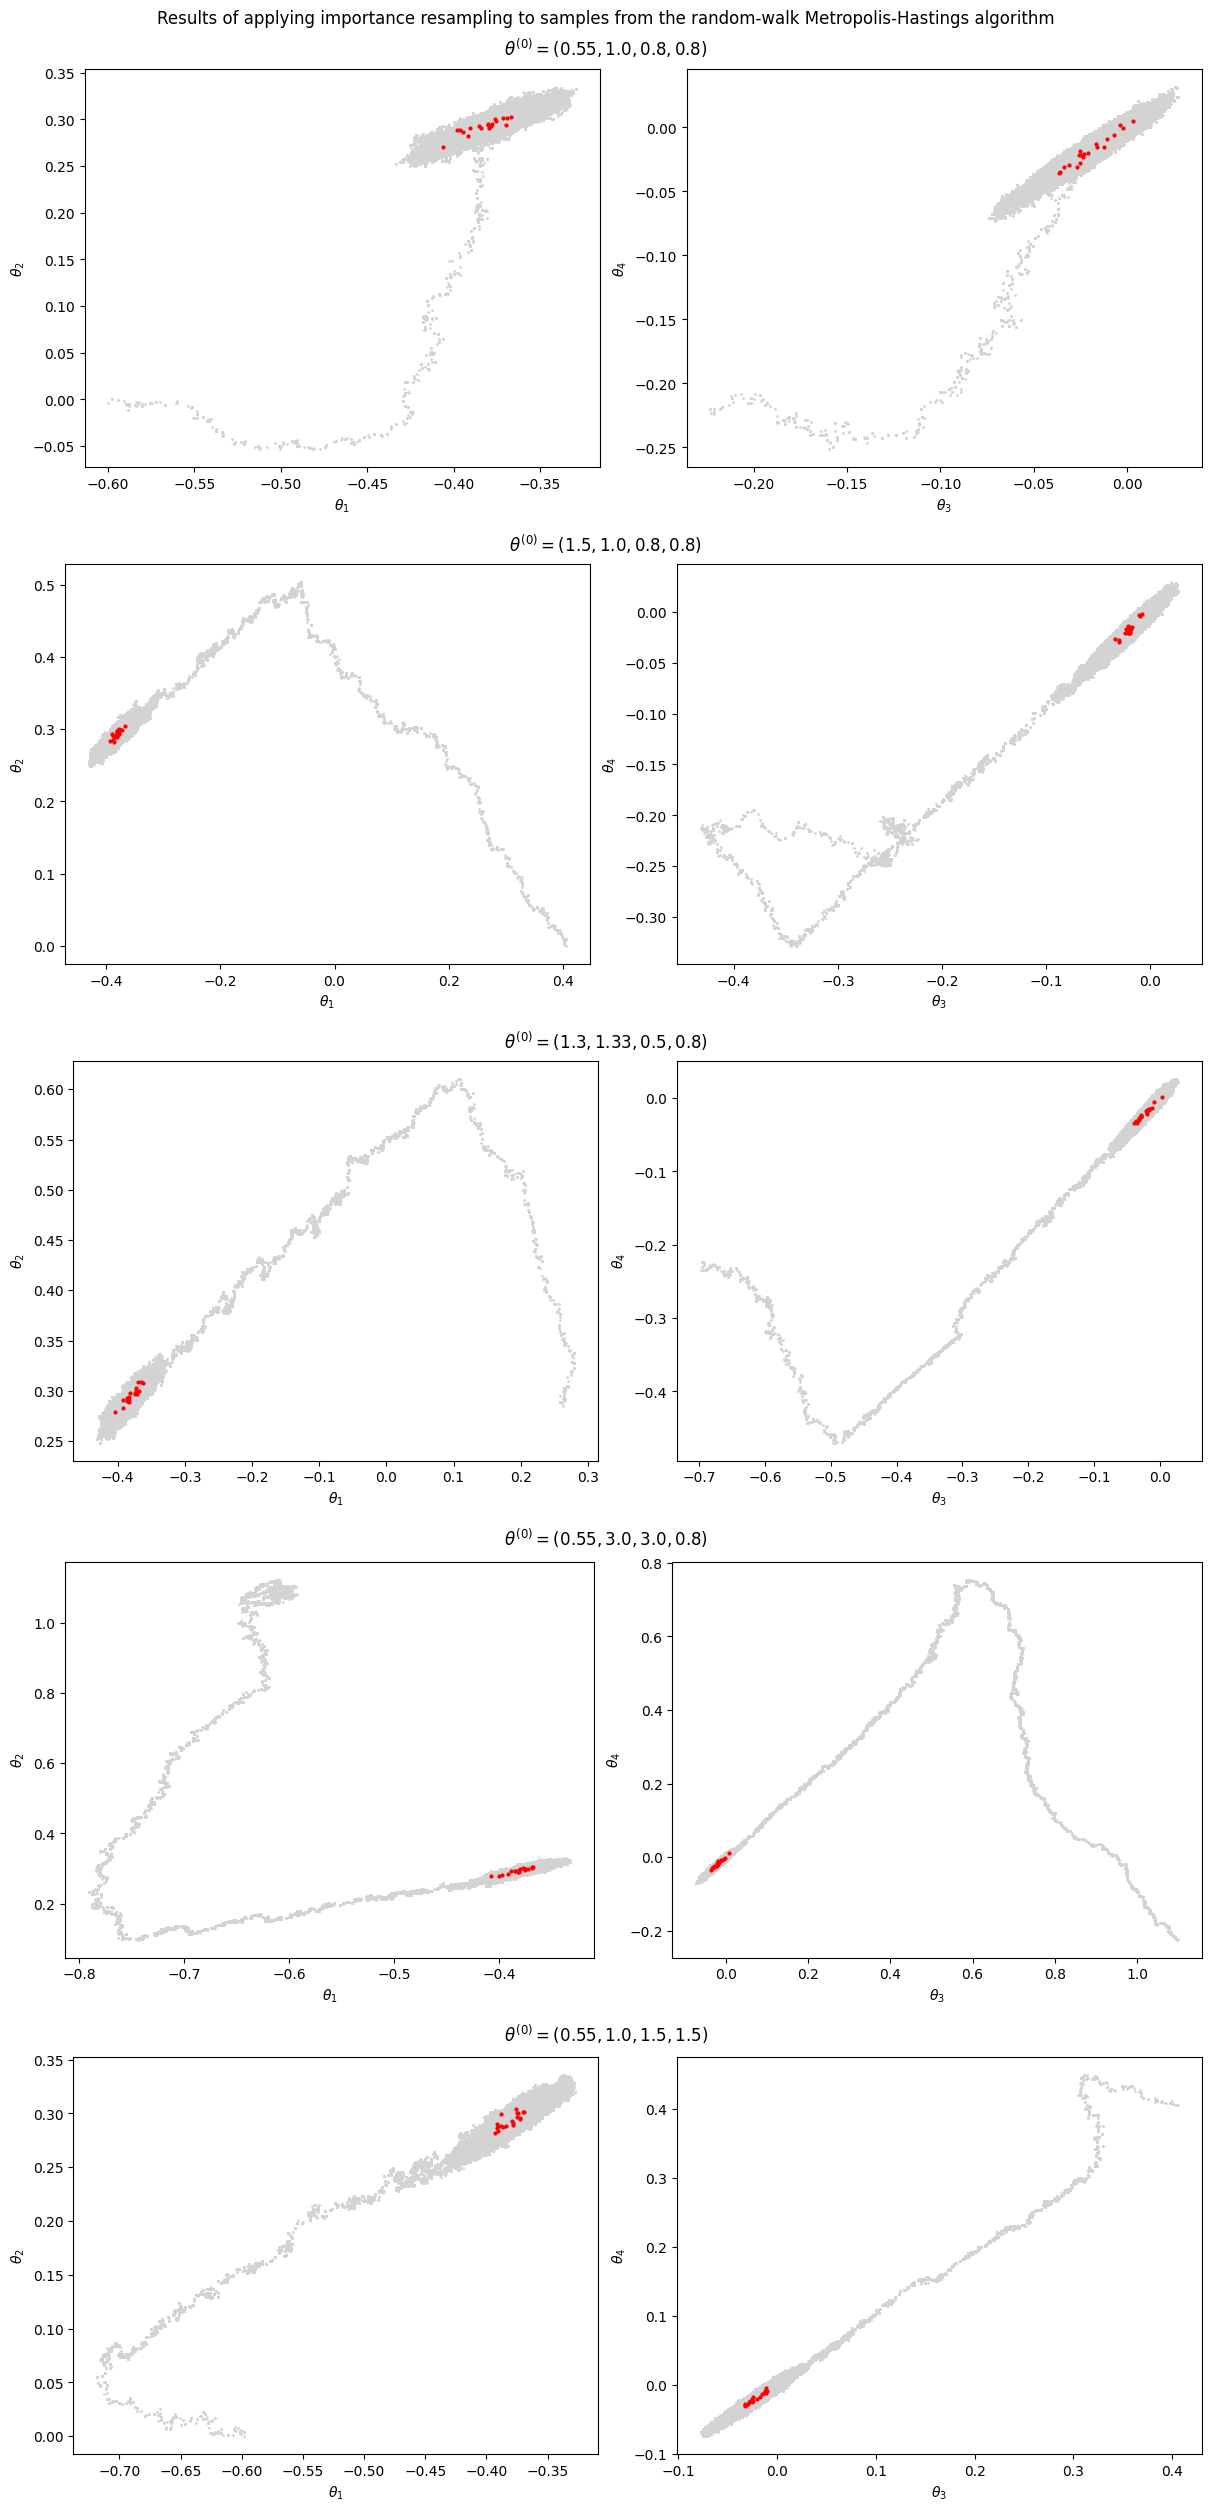

In [83]:
fig = plot_sample_thinned(rw_samples, rw_ir_idx, titles, var_labels);
fig.suptitle('Results of applying importance resampling to samples from the random-walk Metropolis-Hastings algorithm');

In [84]:
hmc_ir_idx = [
    ir_thin(log_p, n_points_thinned, rng) for log_p in hmc_log_p
]

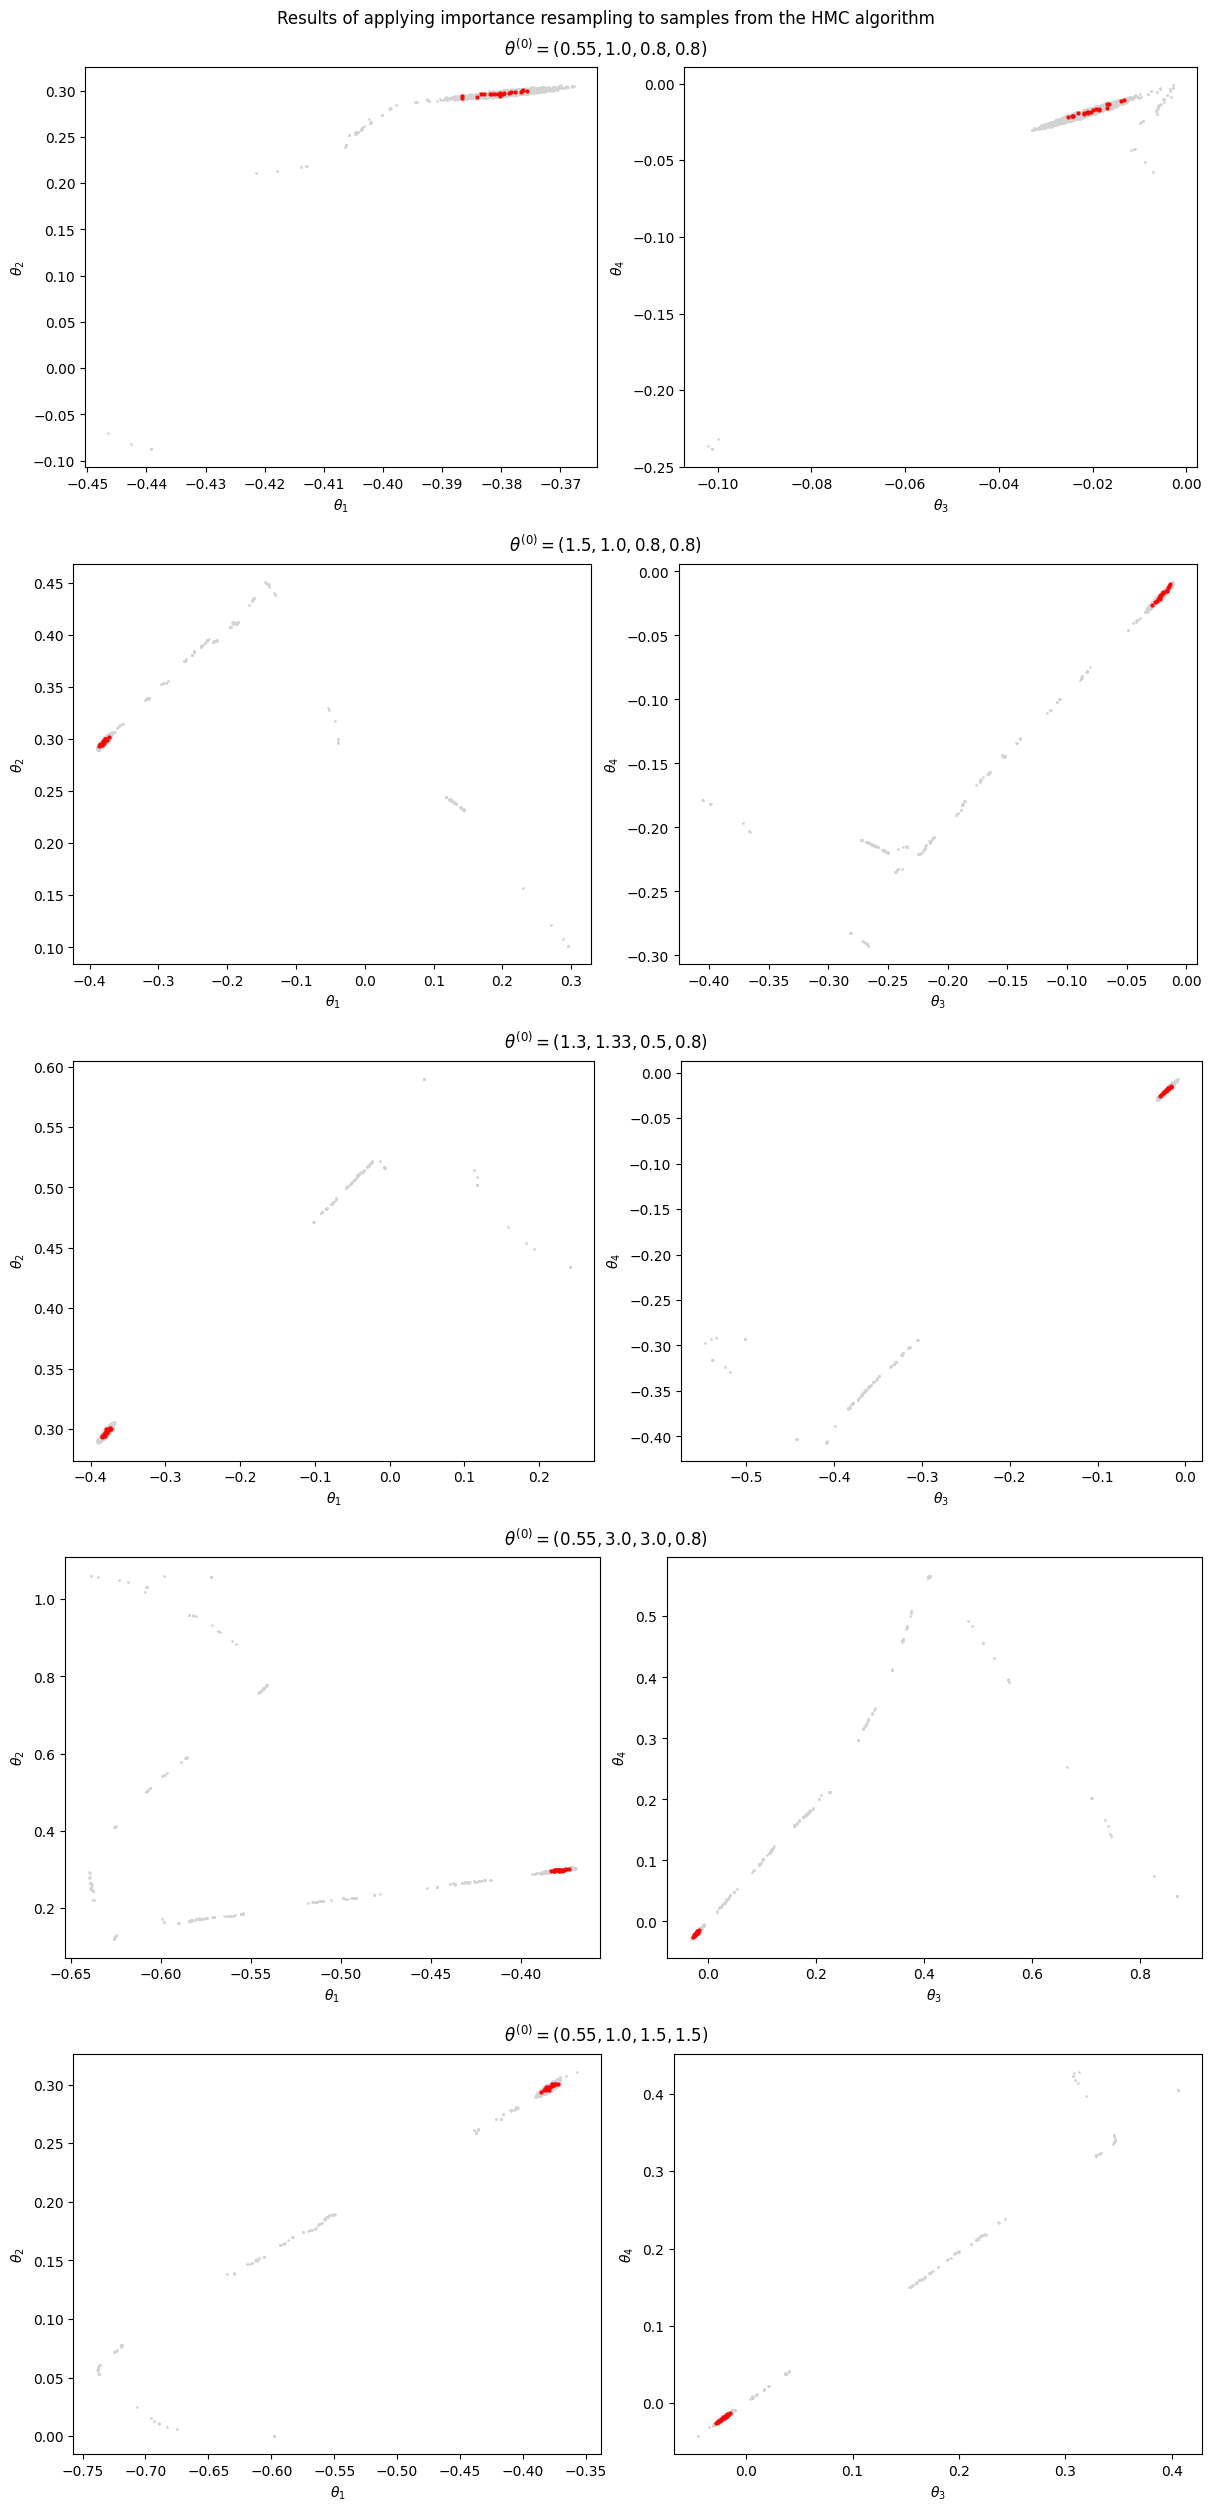

In [85]:
fig = plot_sample_thinned(hmc_samples, hmc_ir_idx, titles, var_labels);
fig.suptitle('Results of applying importance resampling to samples from the HMC algorithm');

# Energy distance comparison

We calculate the energy distance between thinned samples and the validation sample:

In [86]:
def fit_quality(subsample):
    return np.sqrt(dcor.energy_distance(validation_sample[::10], subsample))

In [87]:
def create_fit_table(samples, index_lists, row_names, column_names):
    return pd.DataFrame(
        [[fit_quality(samples[i][indices[i]]) for i in range(len(samples))] for indices in index_lists],
        index=row_names,
        columns=column_names,
    )

In [88]:
%%time
rw_fit = create_fit_table(
    rw_samples,
    [rw_thinned_idx, rw_naive_idx, rw_ir_idx],
    ['Stein thinning', 'Naive thinning', 'Importance resampling'],
    range(1, len(rw_samples) + 1))
rw_fit

CPU times: user 2.88 s, sys: 49.5 ms, total: 2.93 s
Wall time: 2.7 s


,1,2,3,4,5
Stein thinning,0.111244,0.118931,0.105883,0.082949,0.119345
Naive thinning,0.104117,0.111729,0.134127,0.969461,0.122602
Importance resampling,0.078170,0.053989,0.073312,0.070331,0.076584


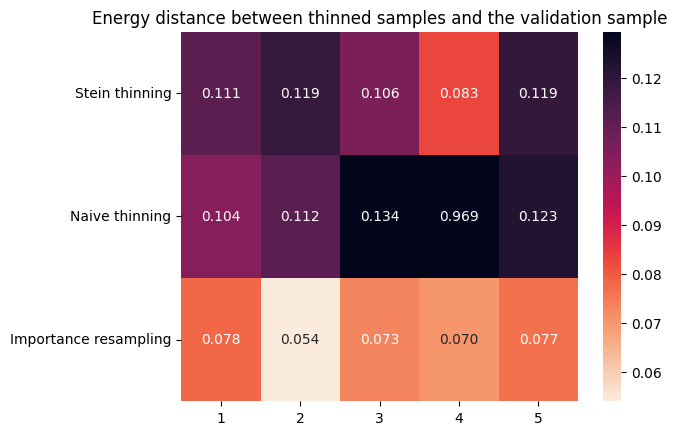

In [89]:
ax = sns.heatmap(rw_fit, annot=True, fmt='.3f', cmap=sns.cm.rocket_r, vmax=np.quantile(rw_fit, 0.9));
ax.set_title('Energy distance between thinned samples and the validation sample');